In [1]:
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

%matplotlib inline

# Custom modules
import const
import func

## Load data

In [2]:
# Load PID to cluster info
#path_id_to_cluster_id = pd.read_csv(os.path.join(const.DATA_PATH, 'path_unique_string_per_station_V0.csv'))
path_id_to_cluster_id = pd.read_csv(os.path.join(const.DATA_PATH, 'eda_product_flow_unique_paths_station_extra_10clusters.csv'))
path_id_to_cluster_id.columns = ['u_arr_ix','cluster']
string_id_to_pid = pd.read_csv(os.path.join(const.DATA_PATH, 'eda_product_flow_sample_paths_station.csv')). \
                      merge(path_id_to_cluster_id, how='left'). \
                      set_index('id')
        

# Manually adjust clusters    
#string_id_to_pid.loc[string_id_to_pid.cluster==3, 'cluster'] = 2
#string_id_to_pid.loc[string_id_to_pid.cluster==7, 'cluster'] = 6
#string_id_to_pid.loc[string_id_to_pid.cluster==4, 'cluster'] = 2

In [3]:
print string_id_to_pid.shape
string_id_to_pid.head()

(2367495, 2)


,u_arr_ix,cluster
id,,
4,13409,1.0
6,7029,10.0
7,12763,1.0
9,13658,1.0
11,9865,1.0


In [4]:
# Load some data analyze previously and aggregated per sample
sample_info = pd.read_csv(os.path.join(const.DATA_PATH, 'eda_prod_info.csv'), index_col=0)

In [5]:
# Load some data analyzed previously and aggregated per sample
sample_info = pd.read_csv(os.path.join(const.DATA_PATH, 'eda_date_sample_aggregation.csv'), index_col=0). \
                 merge(string_id_to_pid, how='left', left_index=True, right_index=True). \
                 merge(sample_info, how='inner', left_index=True, right_index=True)

In [6]:
sample_info.shape

(1183747, 21)

In [7]:
sample_info.head()

,first_station,last_station,min,max,count,delta_max,n_max,Response_x,u_arr_ix,cluster,...,n_categorical_t,n_numeric,n_numeric_t,n_timestamp,n_unknown,sample_nr,t_max,t_min,Response_y,t_delta
Id,,,,,,,,,,,,,,,,,,,,,
4,0.0,113.0,0.0,5.05,14,4.99,105.0,0,13409,1.0,...,83.0,162.0,91.0,179.0,5.0,0.0,87.290001,82.239998,0,5.050003
6,12.0,113.0,0.0,2.63,13,2.58,105.0,0,7029,10.0,...,116.0,192.0,90.0,209.0,3.0,1.0,1315.750000,1313.119995,0,2.630005
7,0.0,113.0,0.0,5.72,13,5.67,105.0,0,12763,1.0,...,114.0,190.0,90.0,207.0,3.0,2.0,1624.420044,1618.699951,0,5.720093
9,0.0,113.0,0.0,4.96,13,4.90,105.0,0,13658,1.0,...,109.0,190.0,93.0,207.0,5.0,3.0,1154.160034,1149.199951,0,4.960083
11,0.0,113.0,0.0,3.38,13,3.33,105.0,0,9865,1.0,...,109.0,190.0,93.0,207.0,5.0,4.0,606.020020,602.640015,0,3.380005


In [8]:
sample_info.loc[sample_info.cluster.isnull(),'cluster']=0
print sample_info.cluster.unique()

[  1.  10.   6.   8.   9.   5.   7.   3.   2.   0.   4.]


In [9]:
# Load look-up table
lut = pd.read_csv(const.LOOK_UP_TABLE)
lut.head()

,line,station,feature_nr,feat_nr_dat,name_dat,name_cat,name_num,station_V2
0,0,0,0,1.0,L0_S0_D1,NaN,L0_S0_F0,0.0
1,0,0,2,3.0,L0_S0_D3,NaN,L0_S0_F2,0.0
2,0,0,4,5.0,L0_S0_D5,NaN,L0_S0_F4,0.0
3,0,0,6,7.0,L0_S0_D7,NaN,L0_S0_F6,0.0
4,0,0,8,9.0,L0_S0_D9,NaN,L0_S0_F8,0.0


In [10]:
# Load unique clusters and covert them to dataframe
paths = pd.read_csv(os.path.join(const.DATA_PATH, 'eda_product_flow_unique_paths_station.csv'), index_col=0)

# Convert strings to int array (could not find a way to split the characters in string other than this...)
paths = (paths.u_str.str.replace('0','0,').str.replace('1','1,').str.split(',')).apply(pd.Series)

# Drop last column (residue after split)
paths.drop(paths.columns[-1], axis=1, inplace=True)

# To ints
paths = paths.astype(int)

# Replace index by station_V2 numbers
paths.columns = lut.groupby('station_V2').station_V2.first().reset_index(drop=True).values

paths.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,1


In [70]:
y=func.read_last_column('train_numeric.csv')#[:500000]

In [73]:
y.Response.value_counts()

0    1176868
1       6879
Name: Response, dtype: int64

In [71]:
y.head(3)

,Response
0,0
1,0
2,0


In [72]:
n_1 = y[y.Response==1].index.values
n_0 = y[y.Response==0].index.values

## Analyze paths

In [31]:
print('Number of stations: {}'.format(paths.shape[1]))
print('Number of paths: {}'.format(paths.shape[0]))

Number of stations: 129
Number of paths: 15210


In [12]:
# Stations that occur most often in unique paths
paths.sum().sort_values().tail()

33.0    10856
34.0    11302
30.0    11942
29.0    12054
37.0    12131
dtype: int64

In [13]:
# Stations that occur least often in unique paths
paths.sum().sort_values().head(10)

24.302      0
46.000      1
24.204      2
24.105      2
25.103      3
42.000     30
25.200     87
25.221     95
25.218    127
25.219    172
dtype: int64

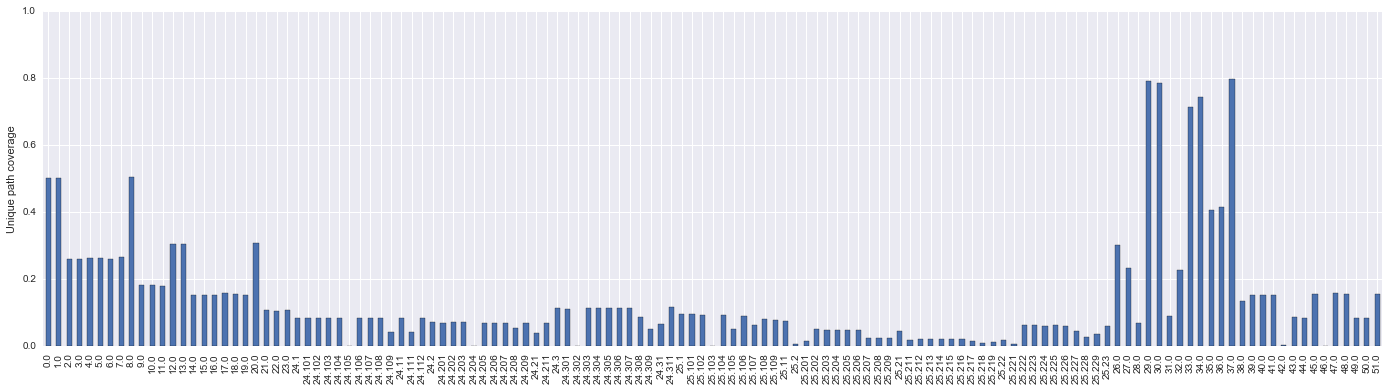

In [14]:
ax = (paths.sum()/paths.shape[0]).plot(kind='bar', figsize=(24,6), ylim=[0,1])
ax.set_ylabel(ylabel='Unique path coverage')

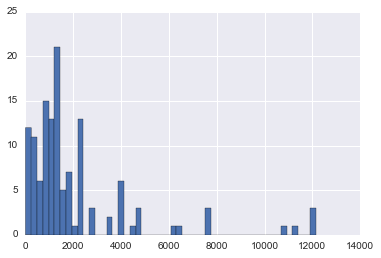

In [15]:
paths.sum().hist(bins=50)

In [16]:
paths.iloc[:2]

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,1


In [17]:
corr_mat = paths.corr()

/Users/joostbloom/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


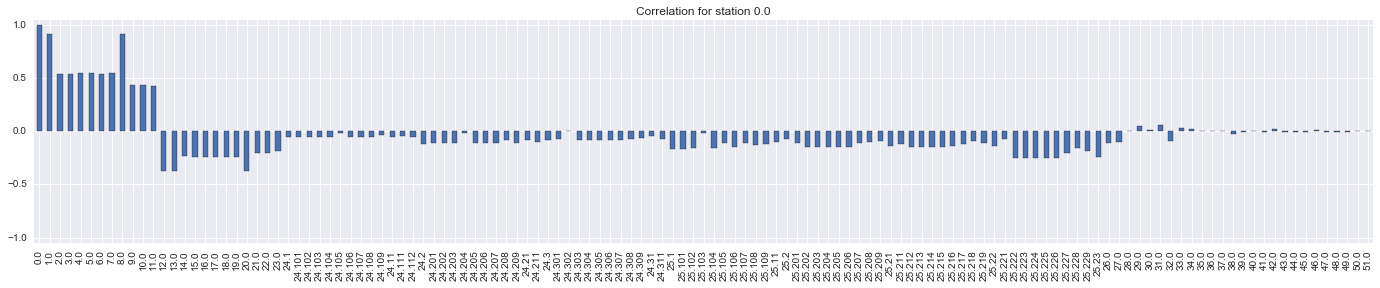

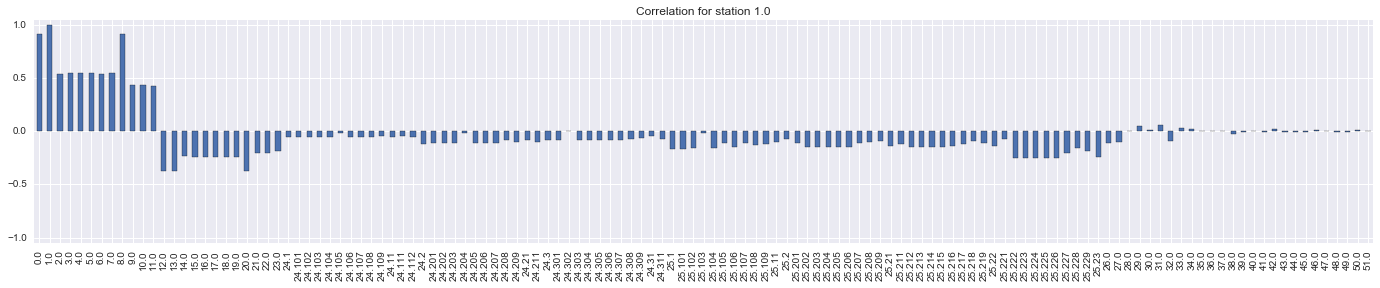

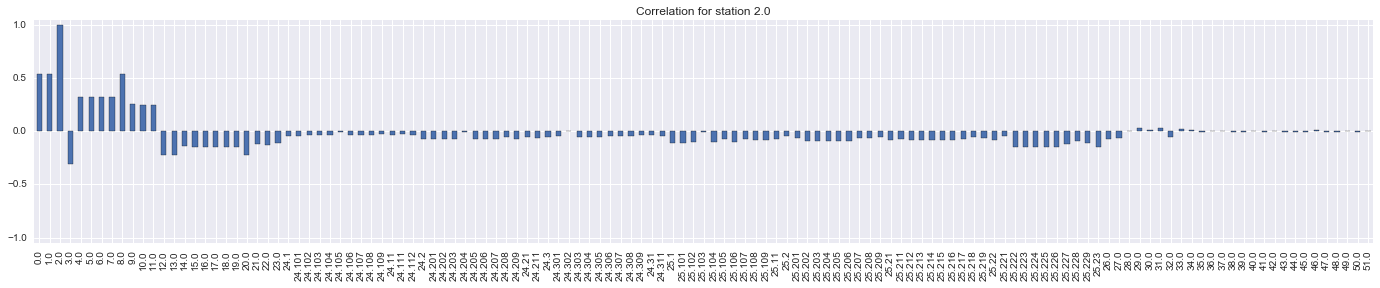

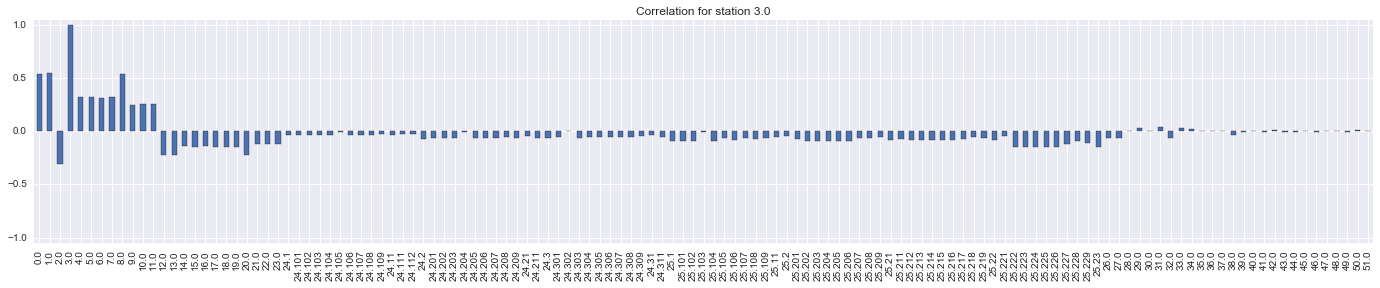

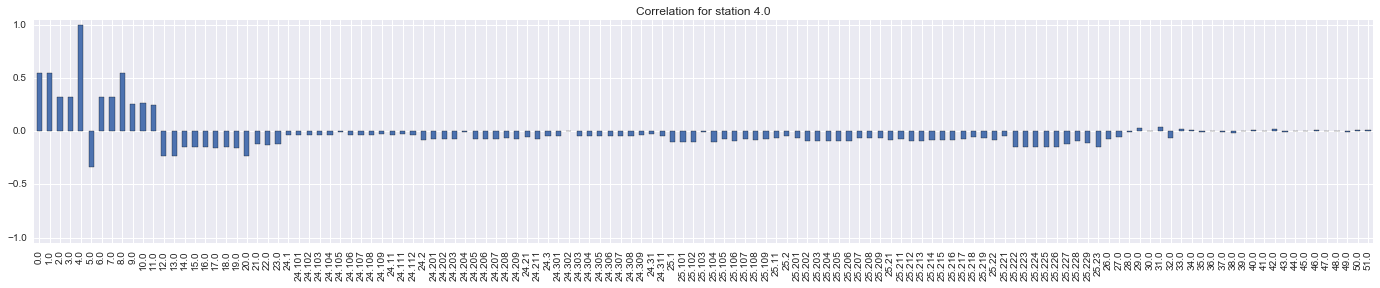

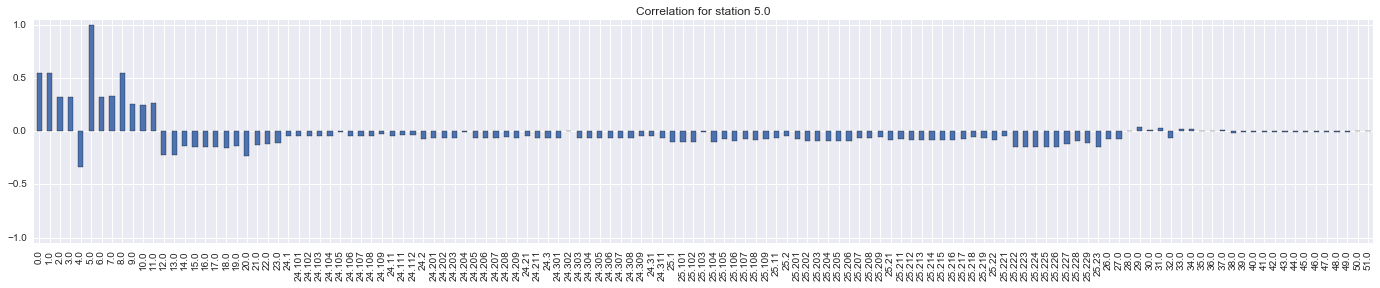

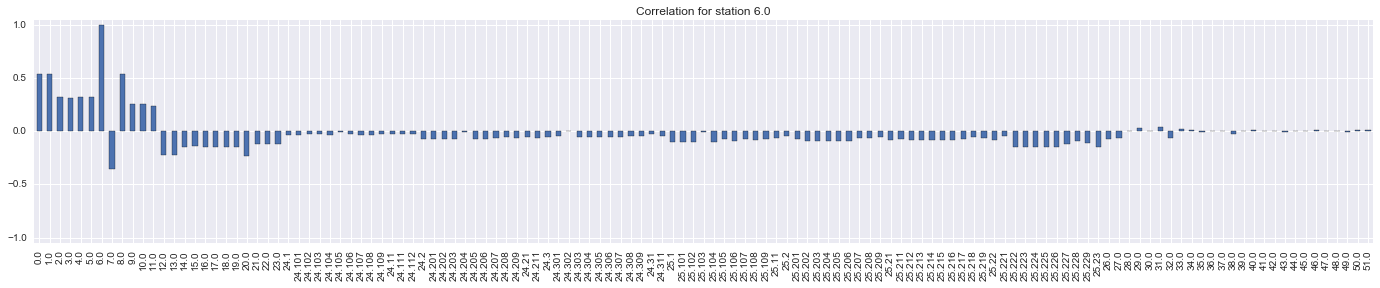

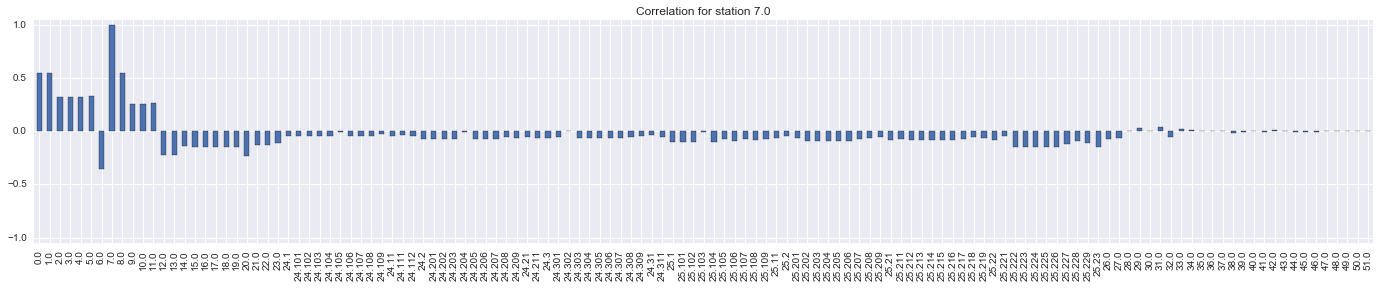

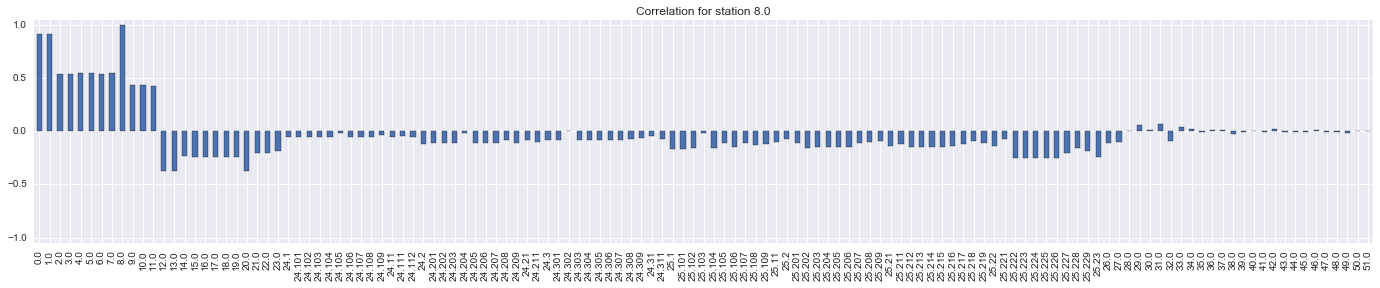

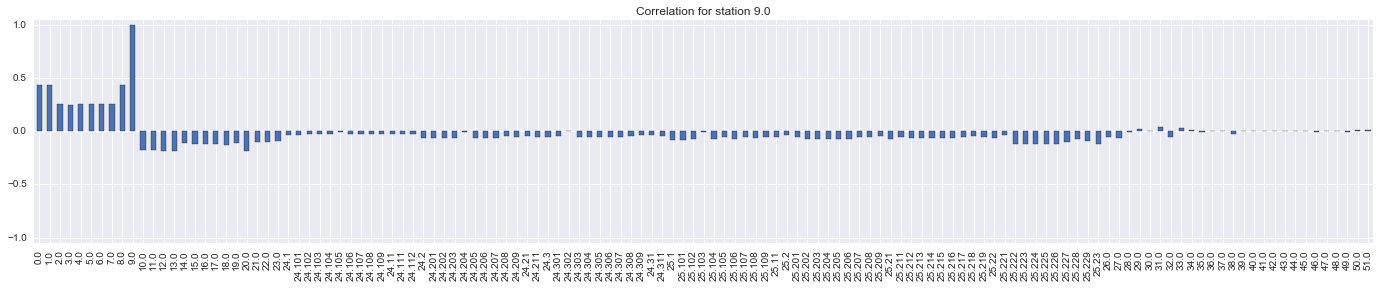

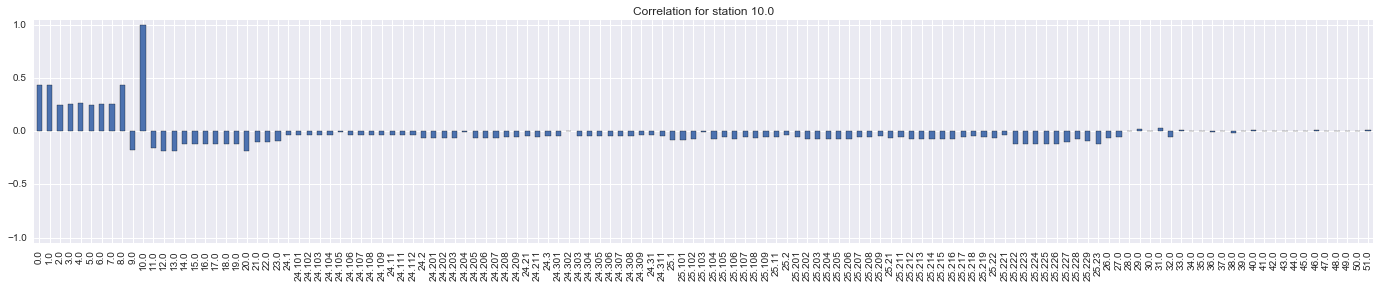

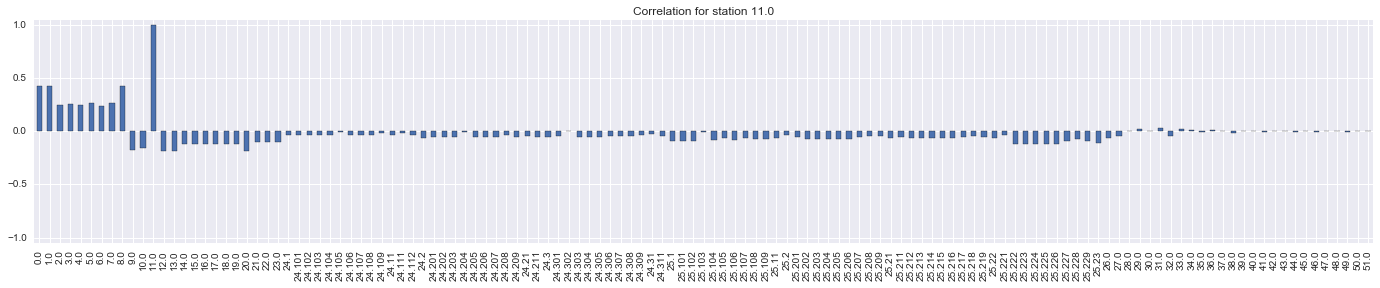

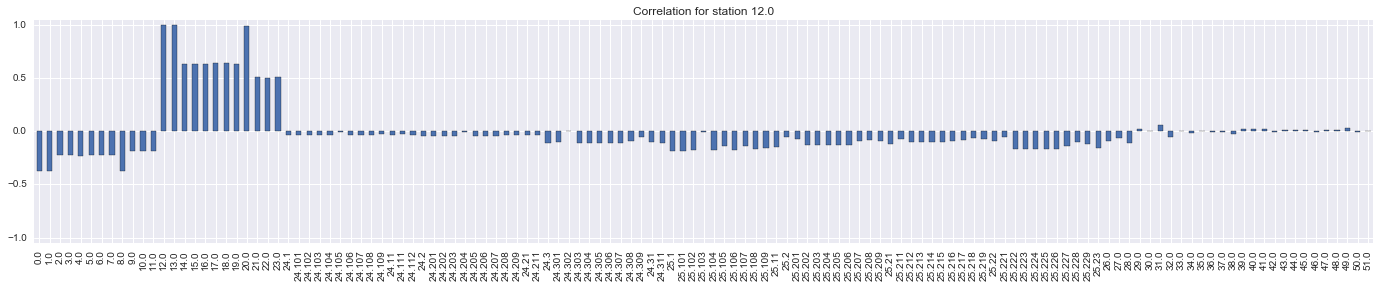

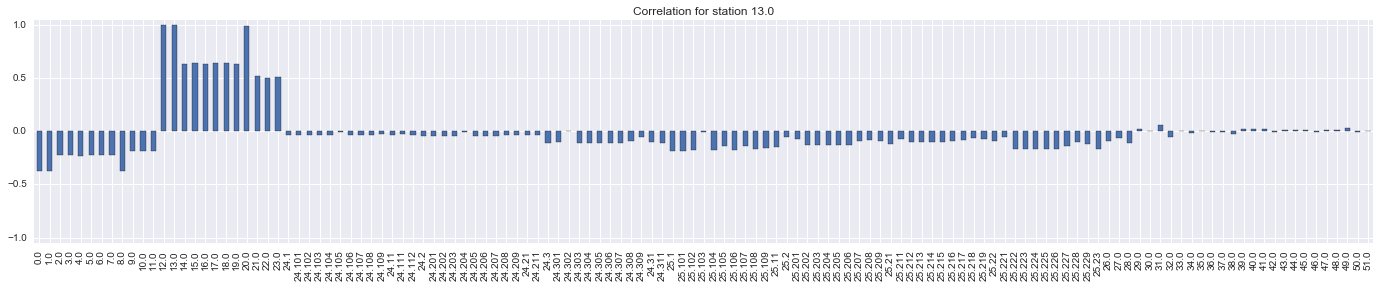

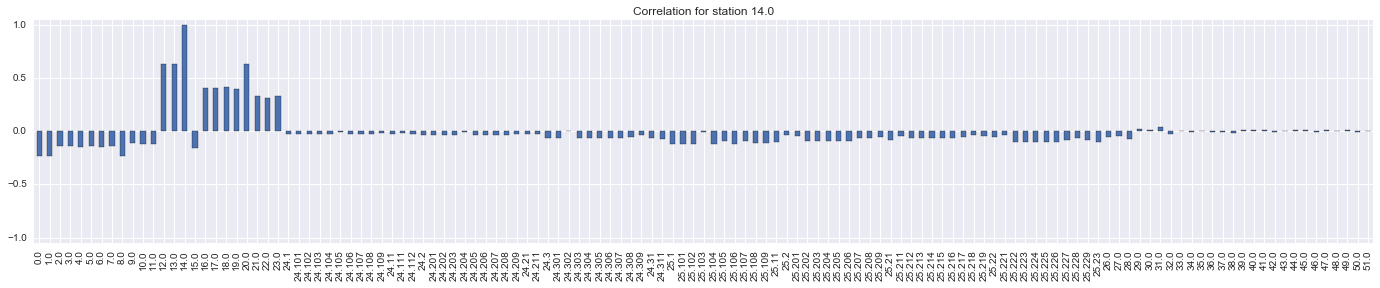

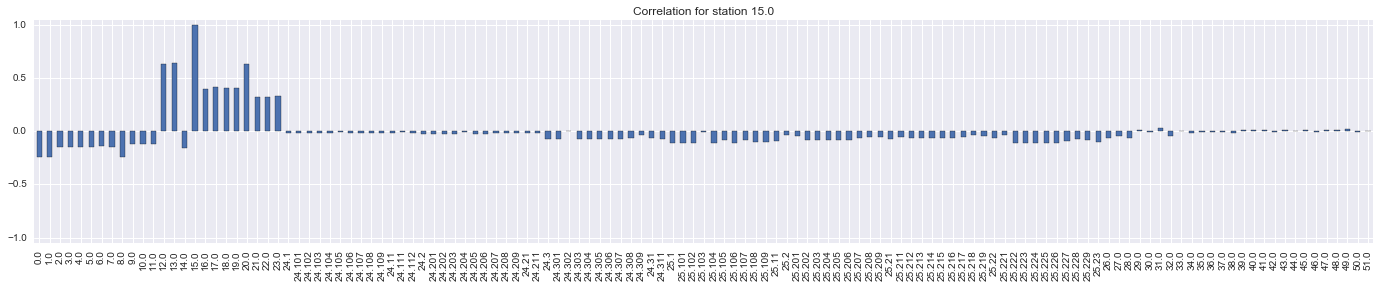

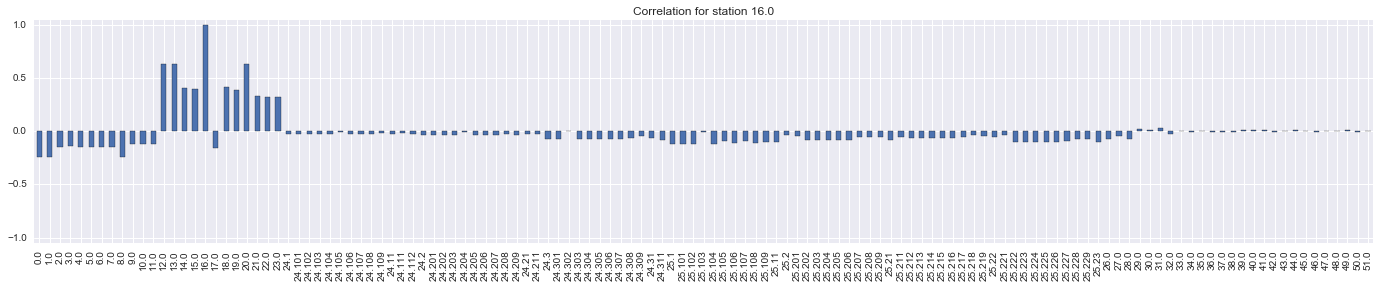

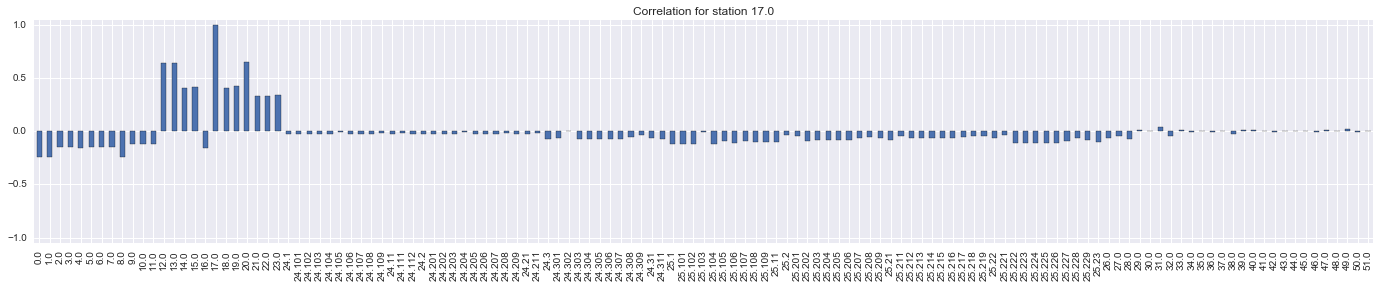

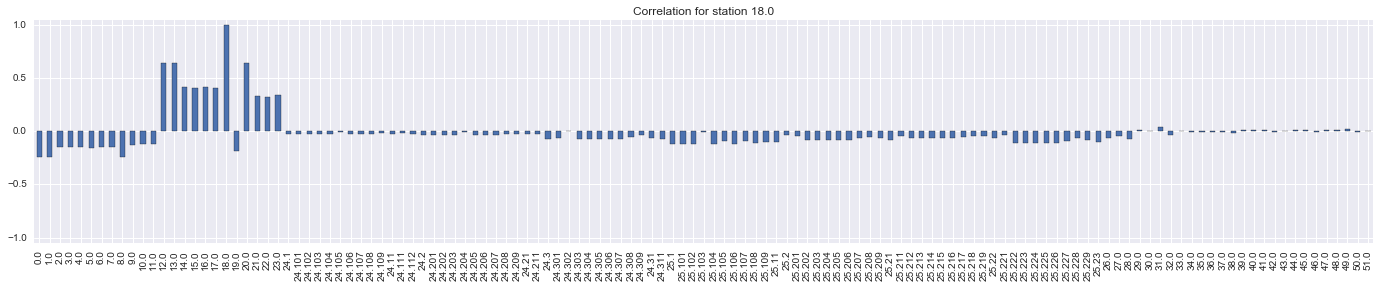

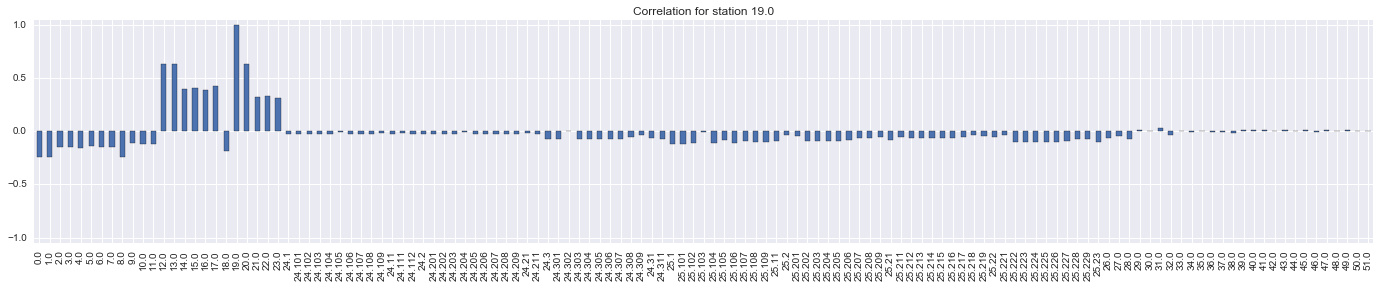

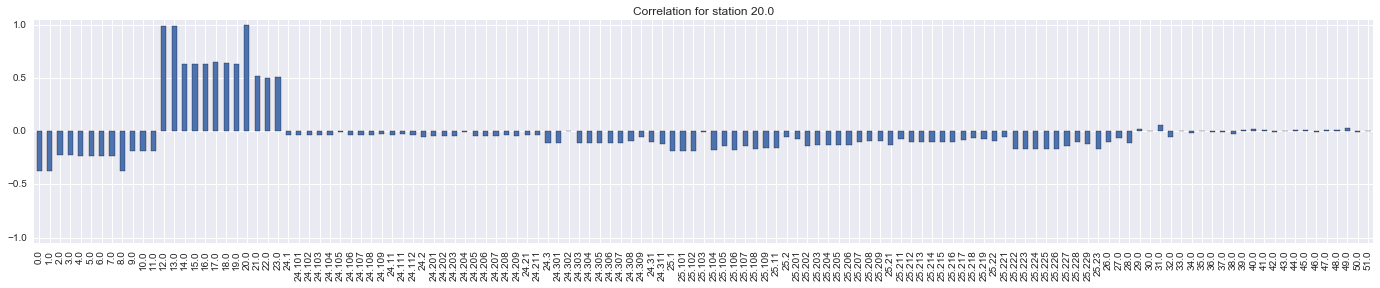

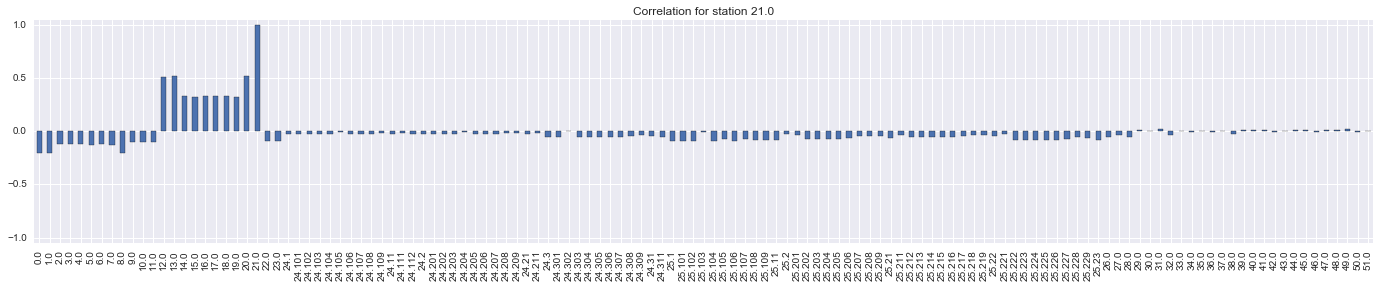

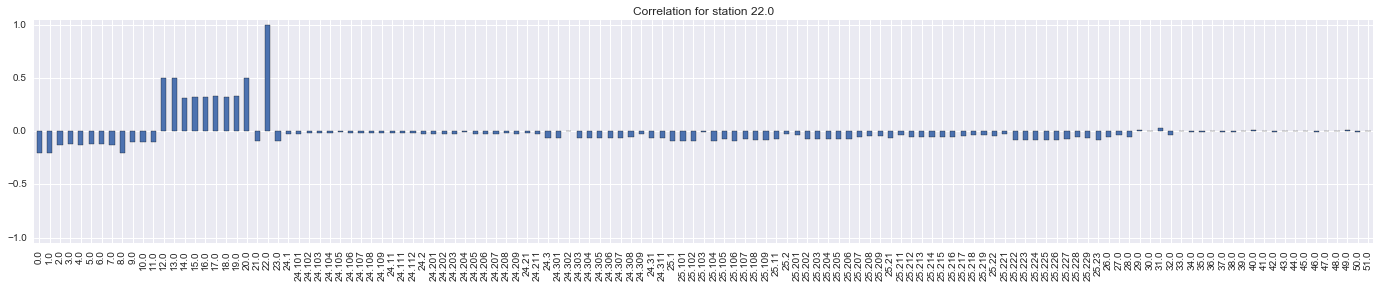

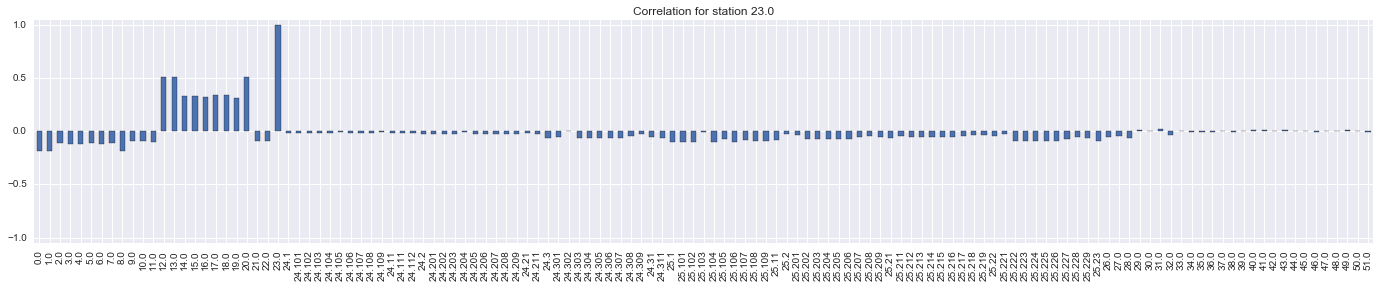

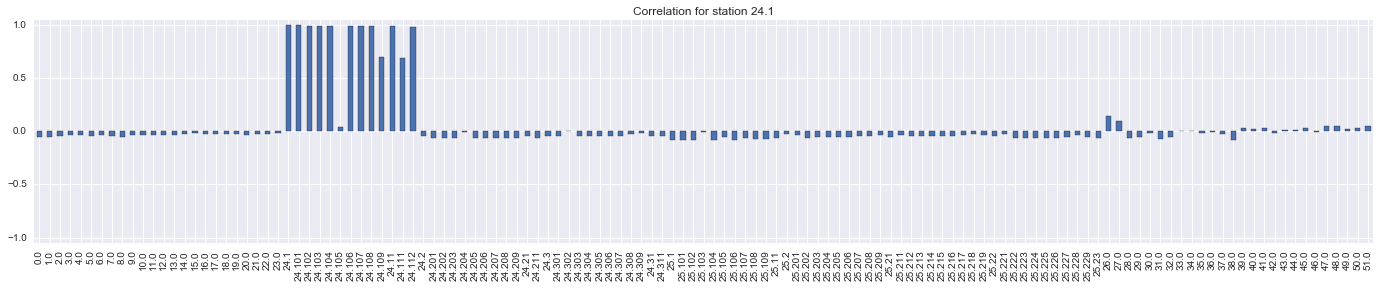

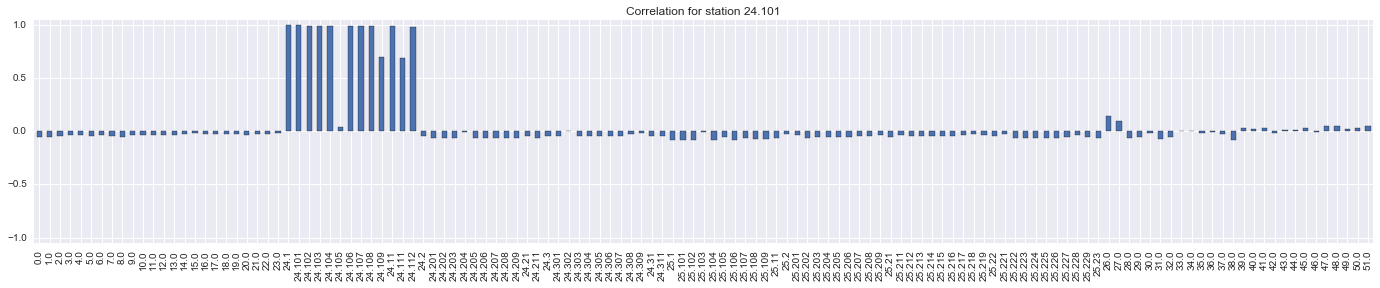

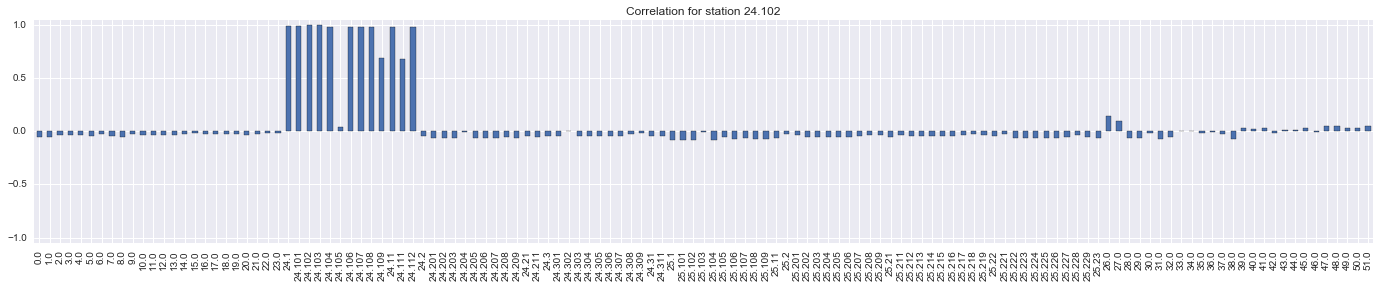

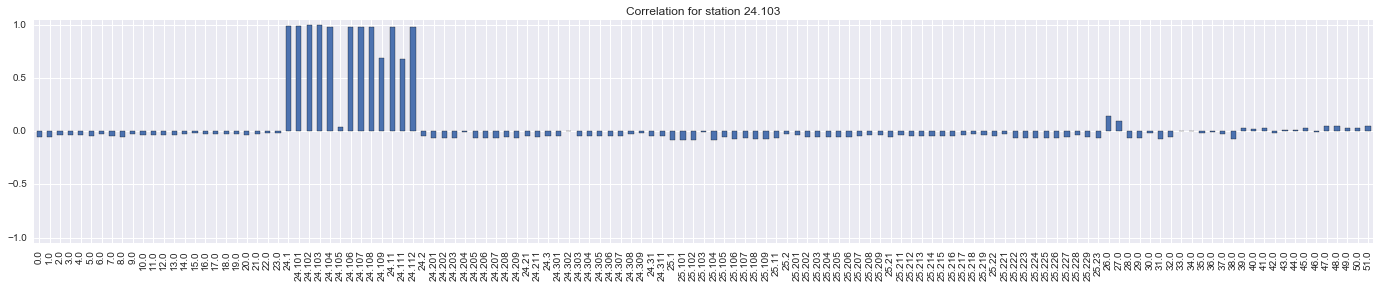

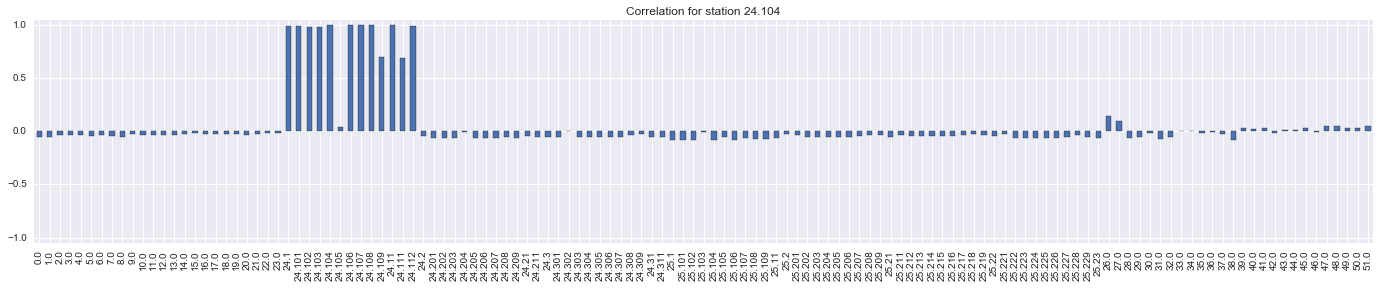

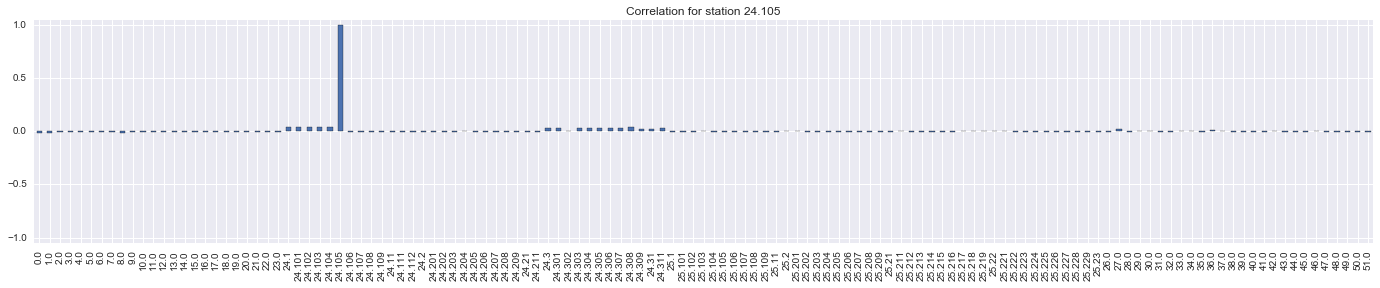

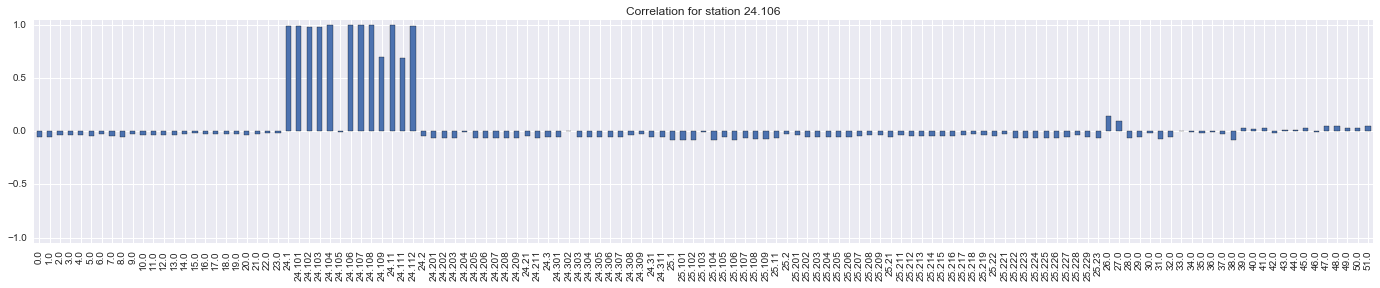

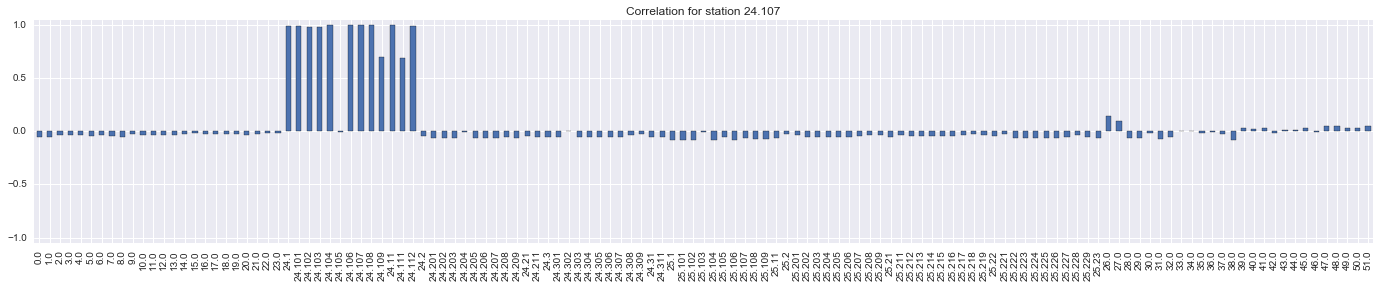

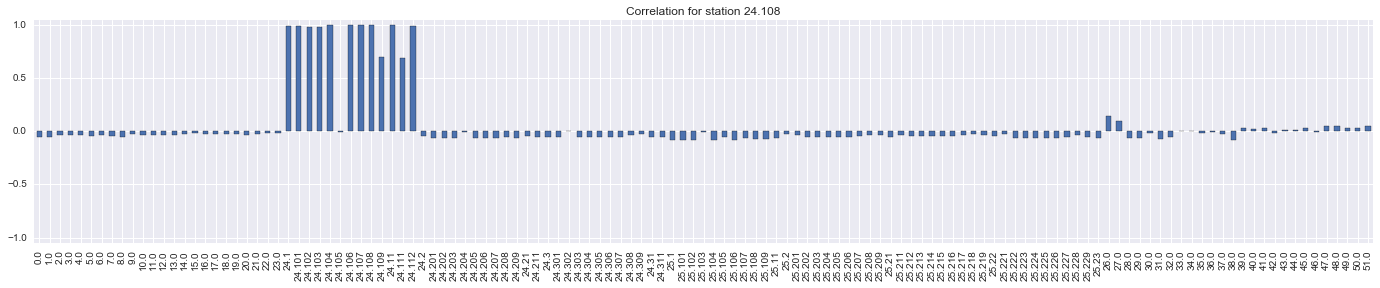

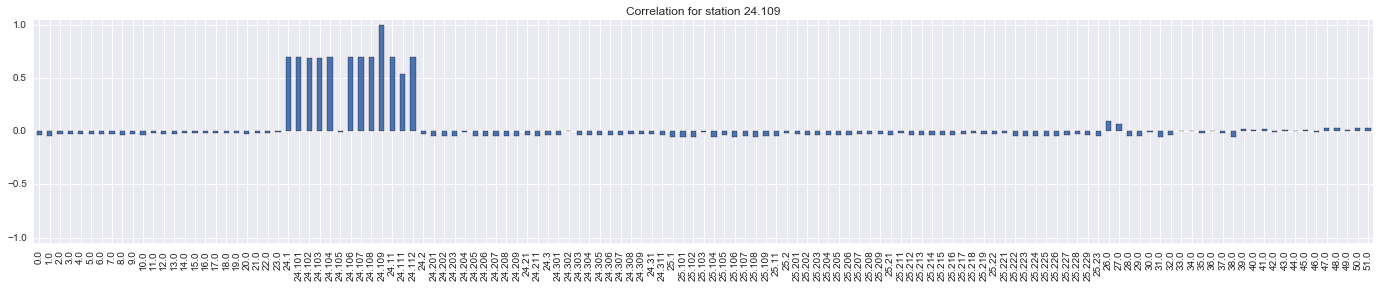

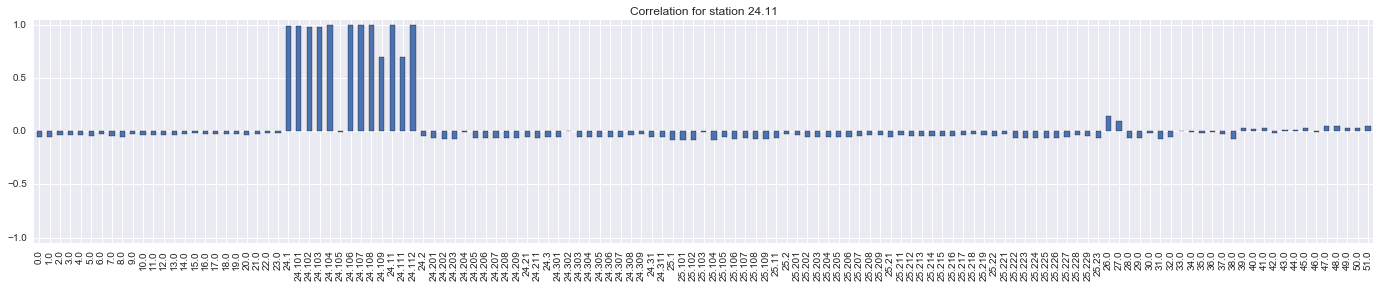

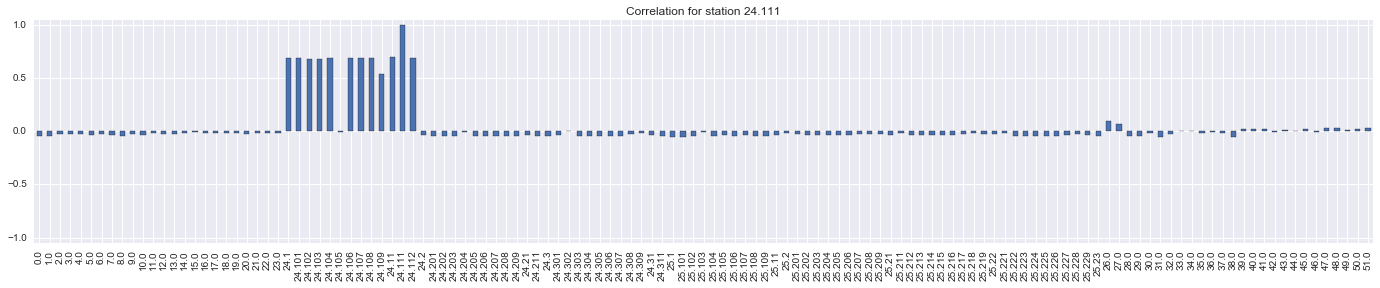

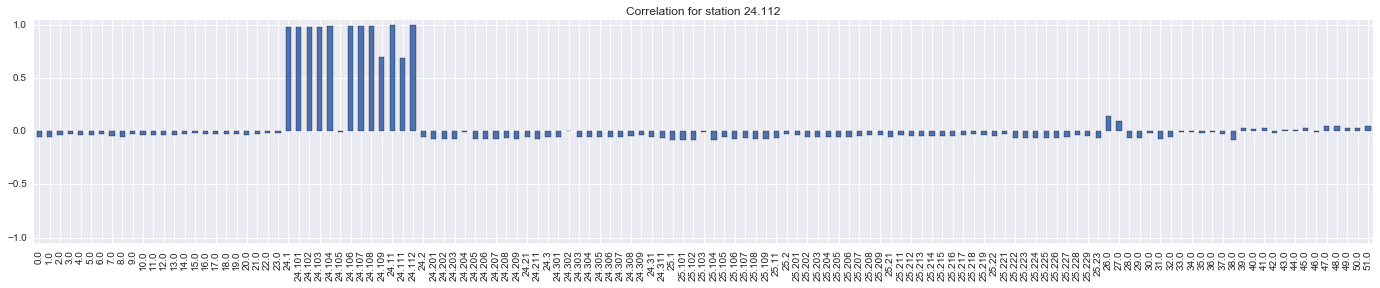

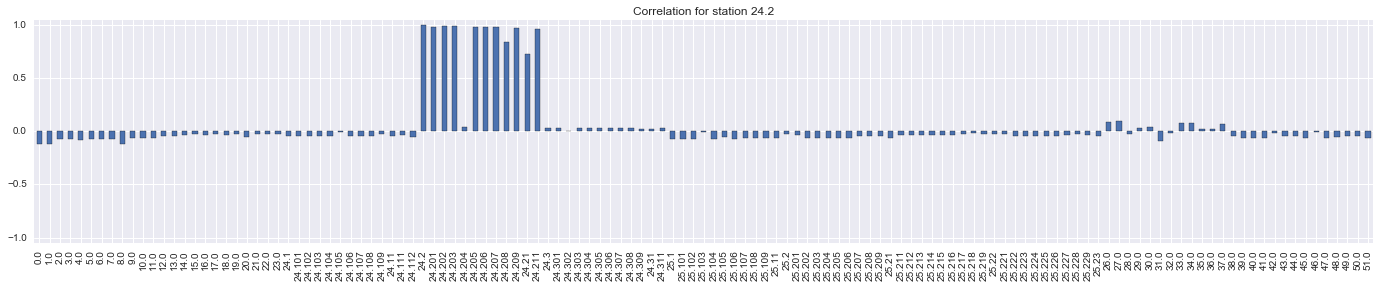

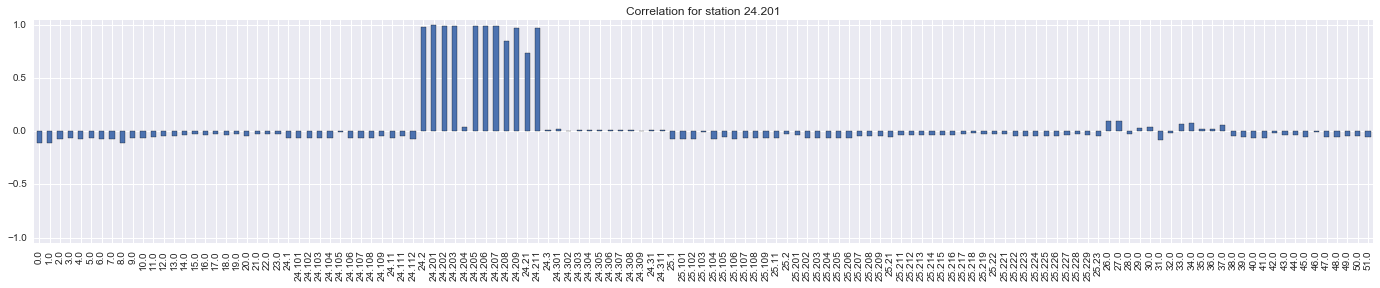

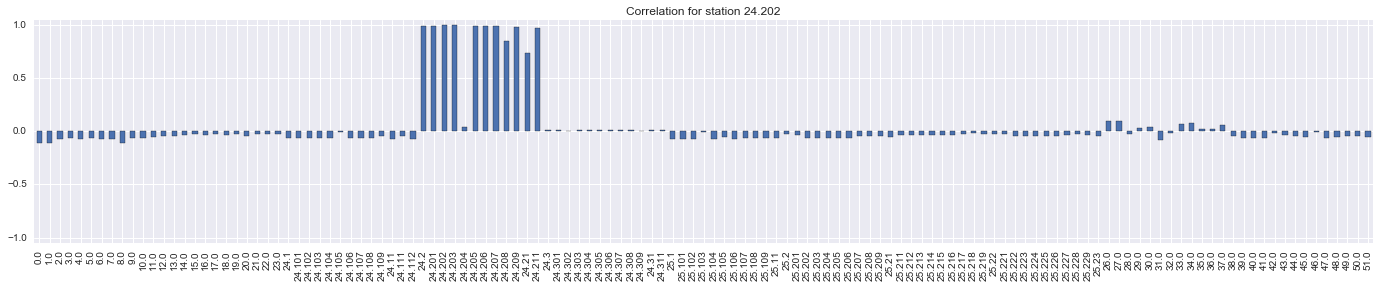

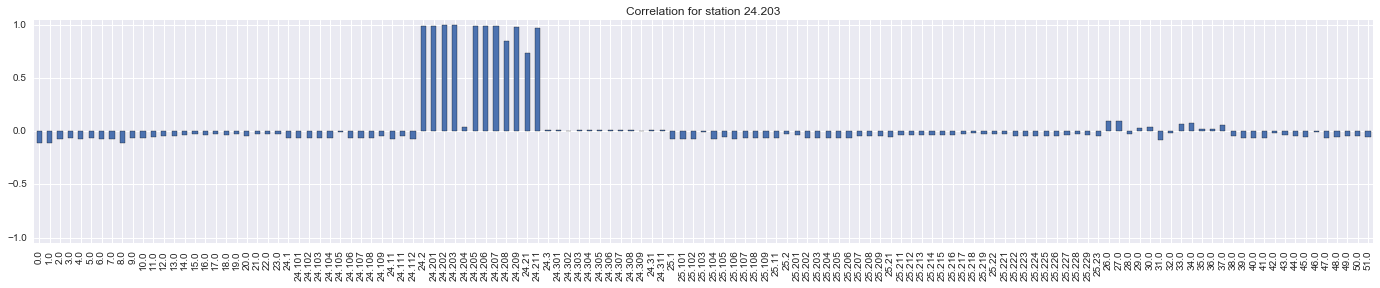

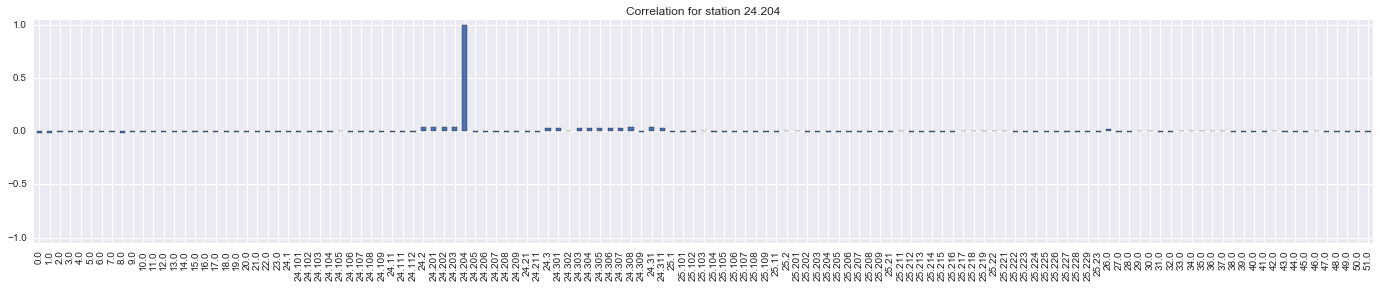

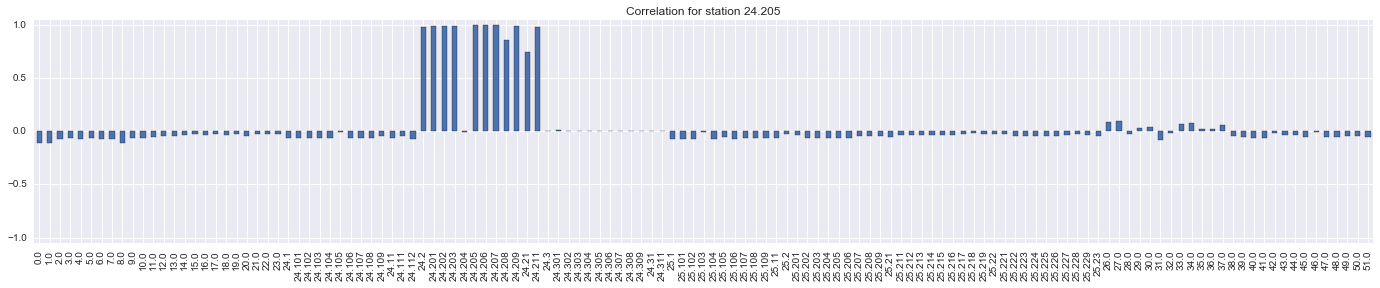

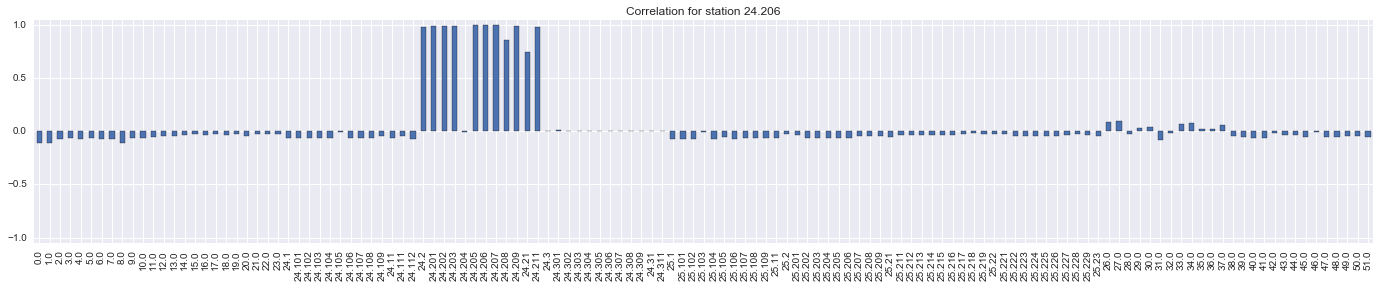

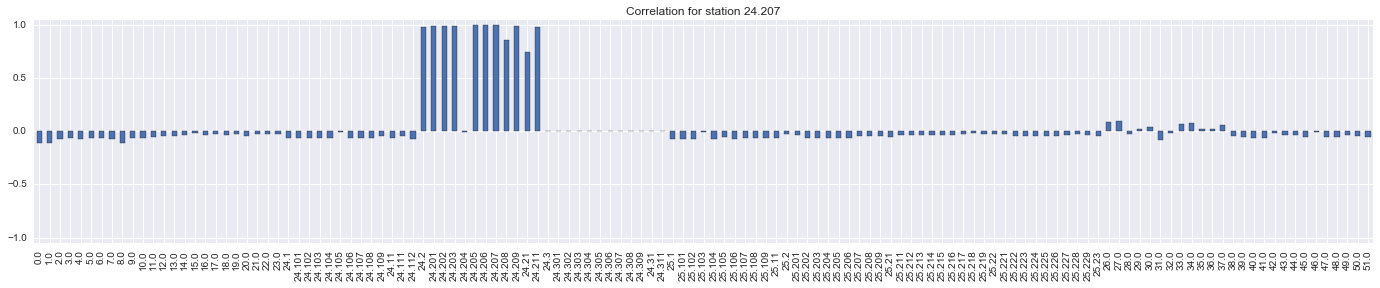

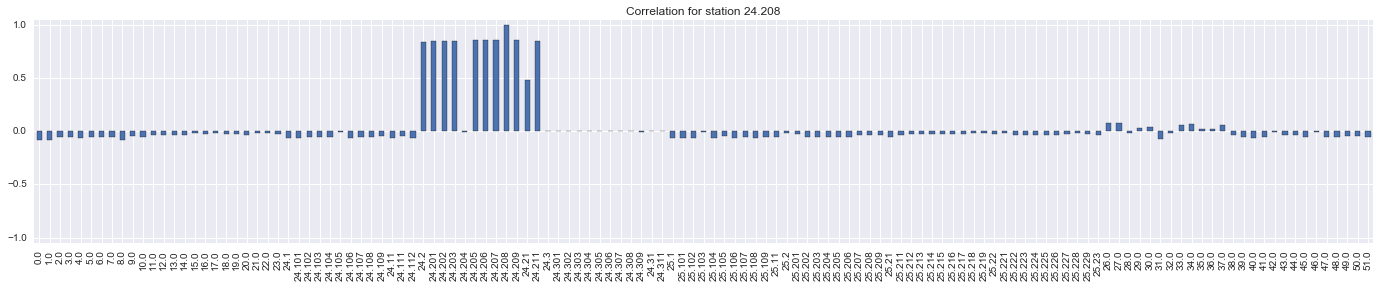

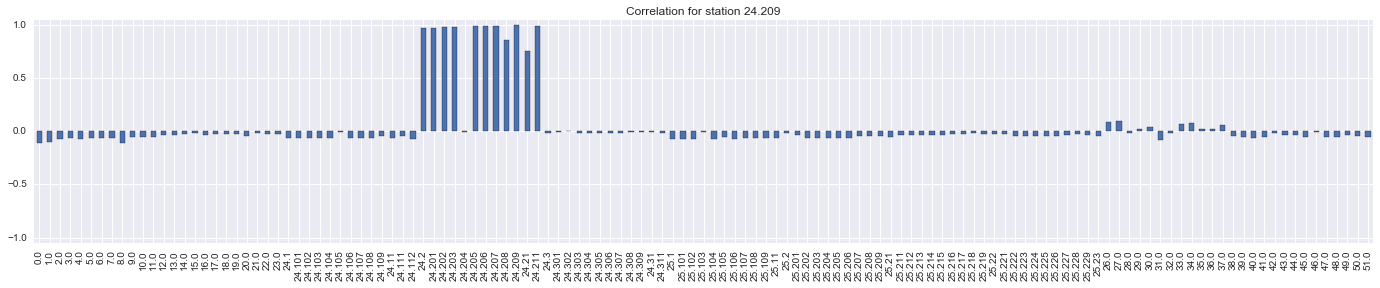

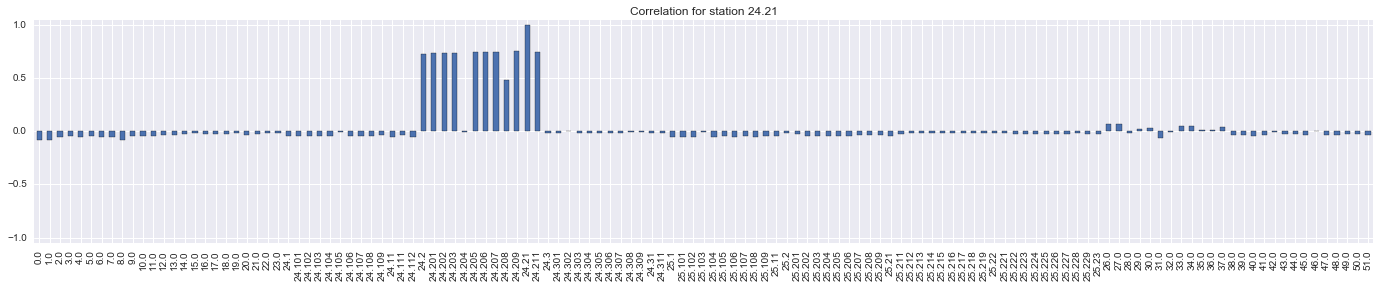

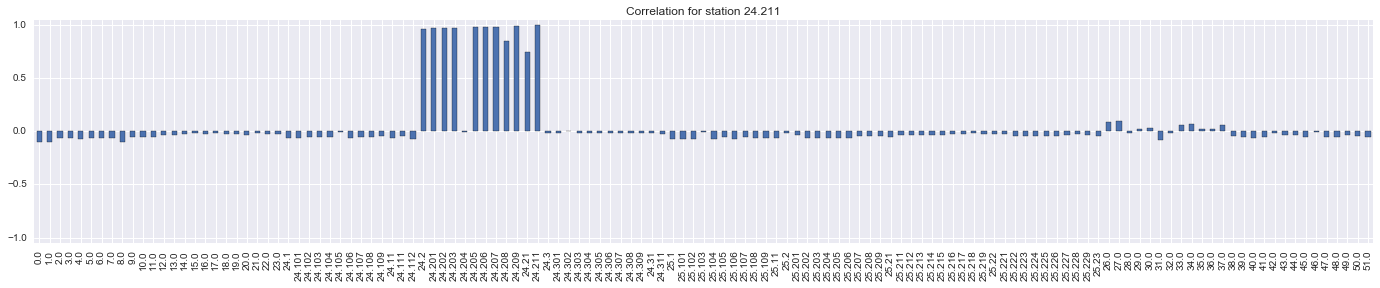

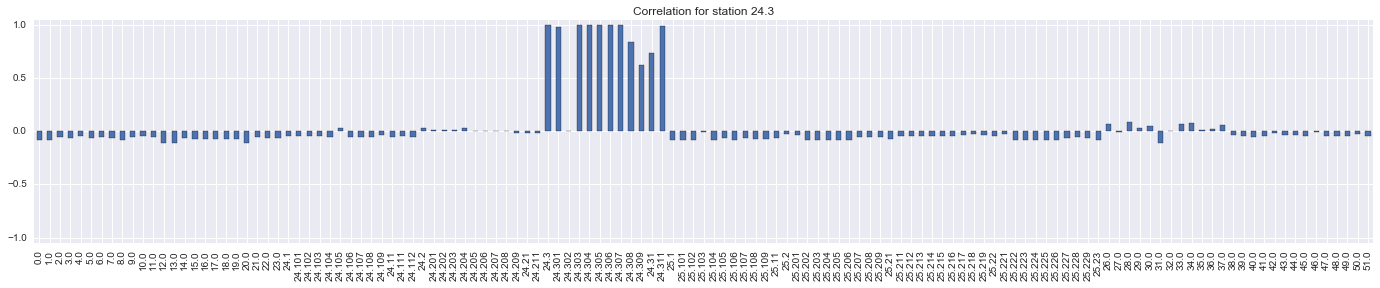

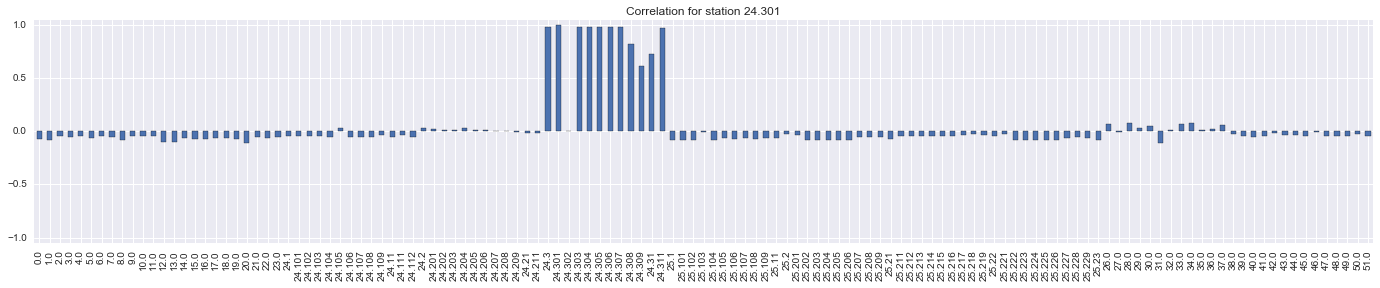

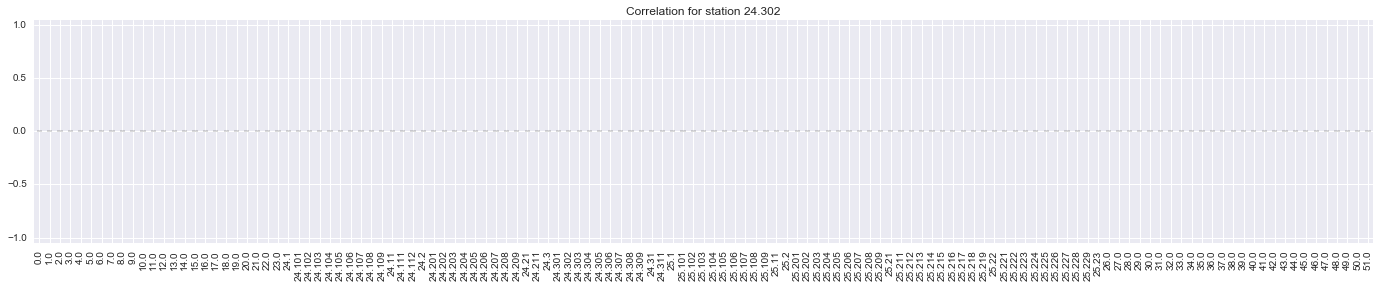

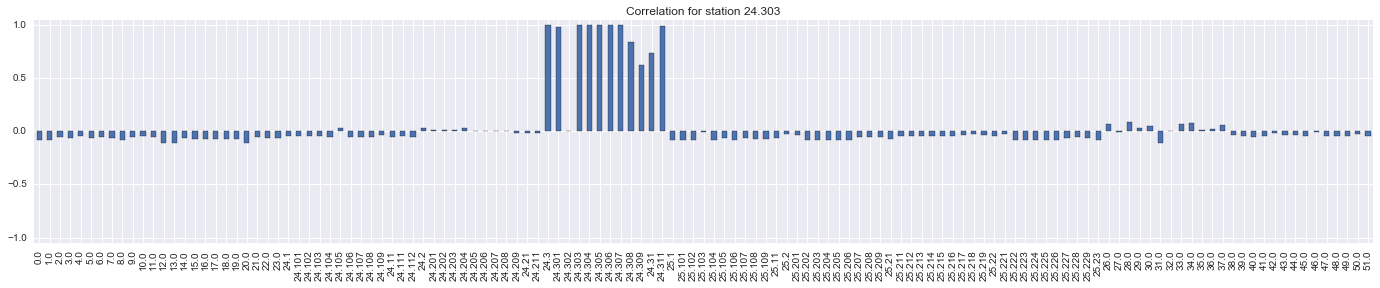

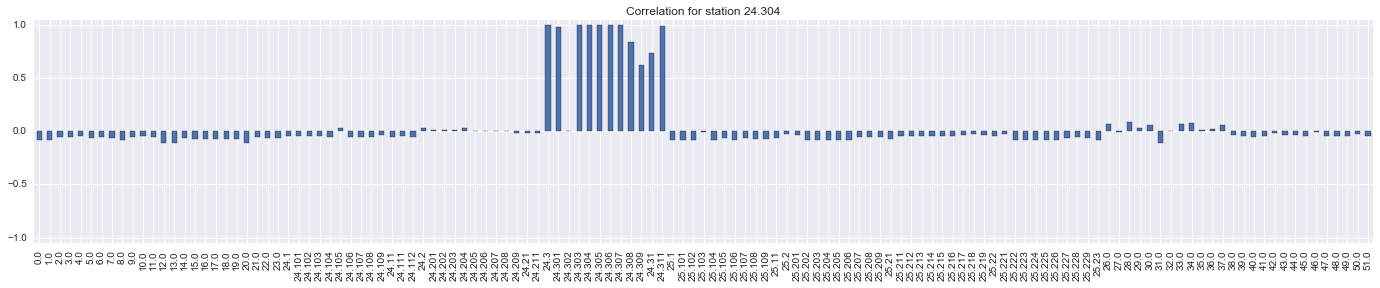

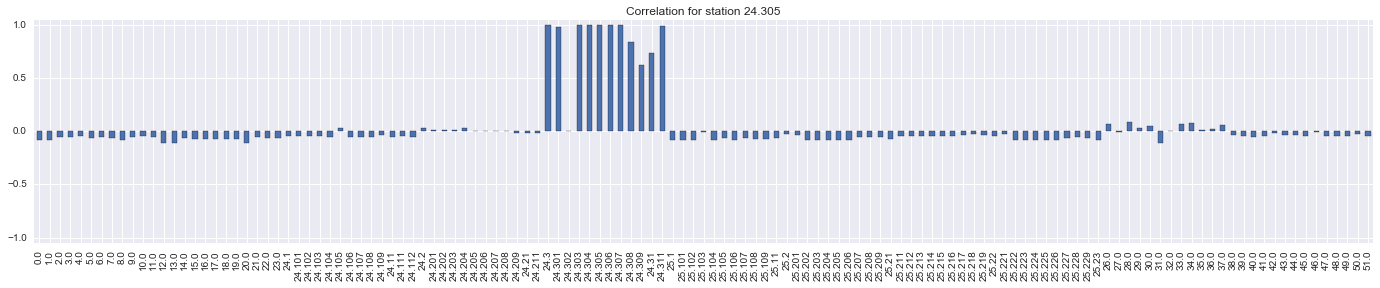

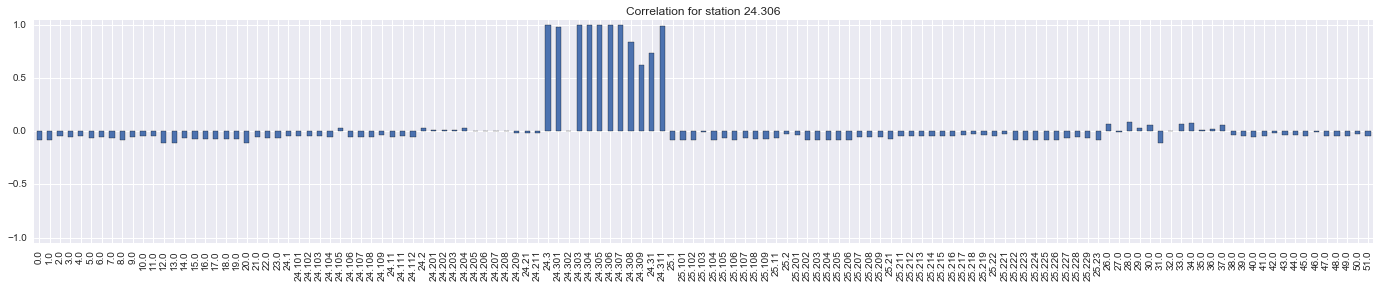

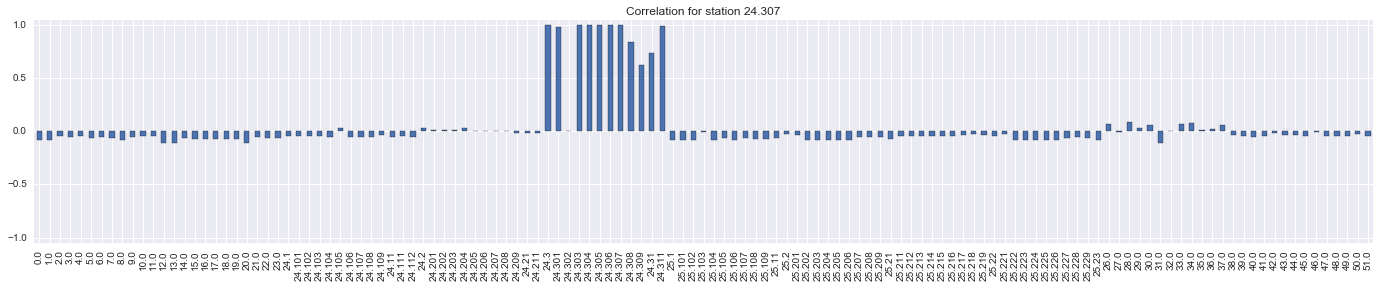

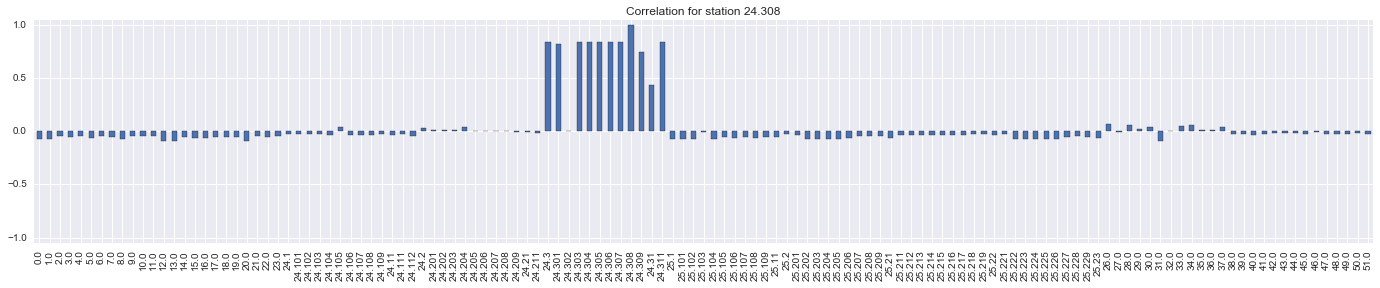

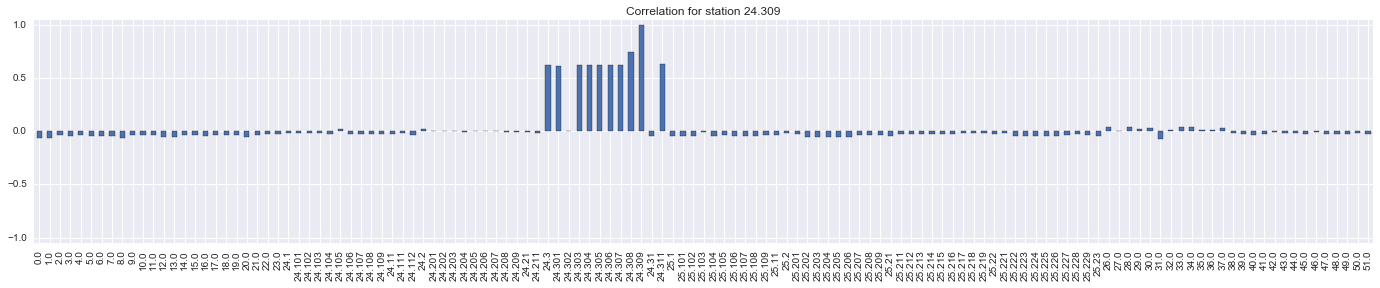

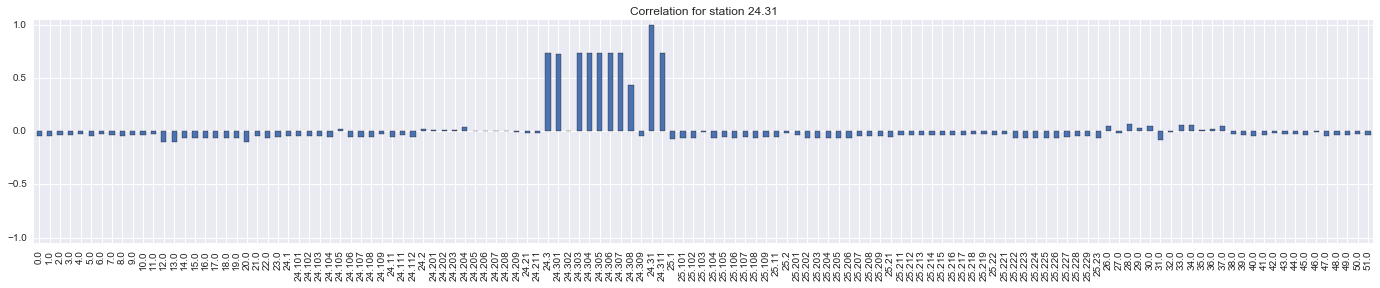

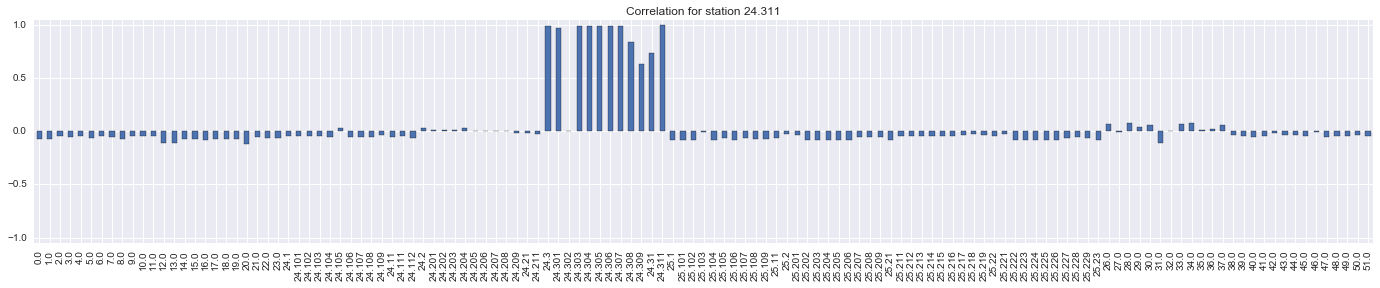

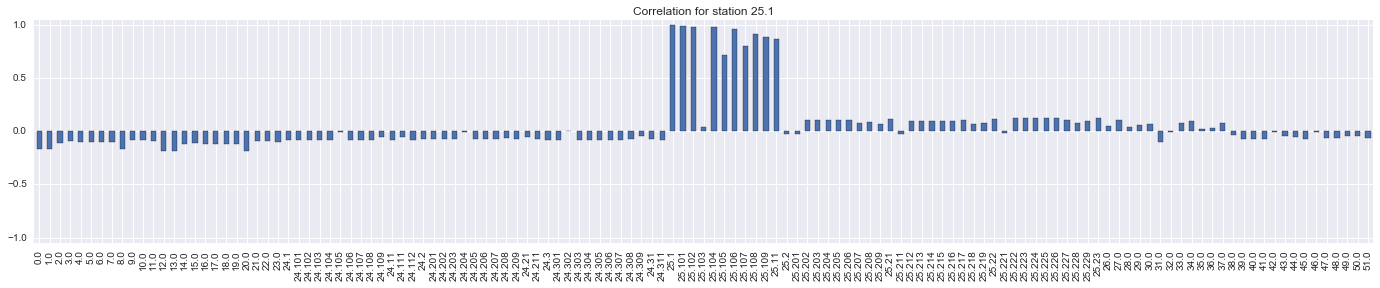

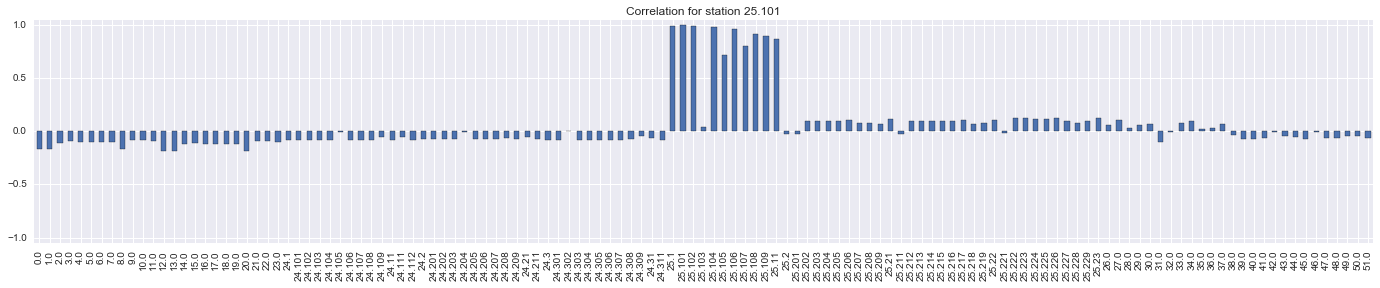

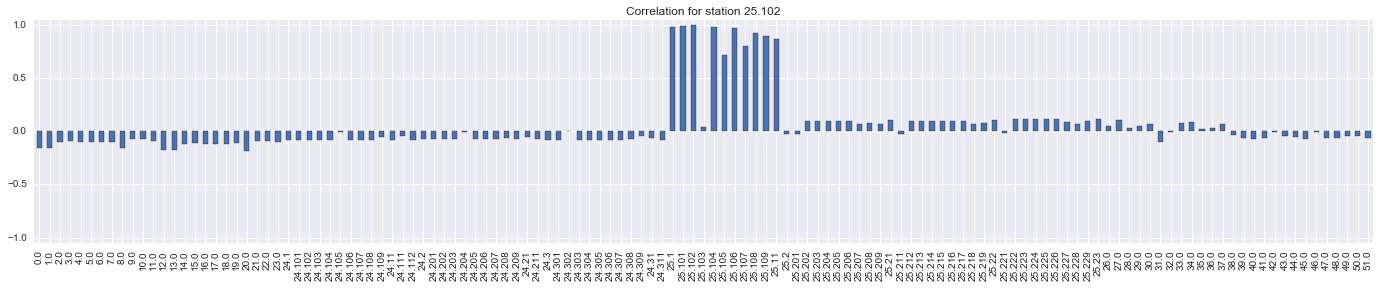

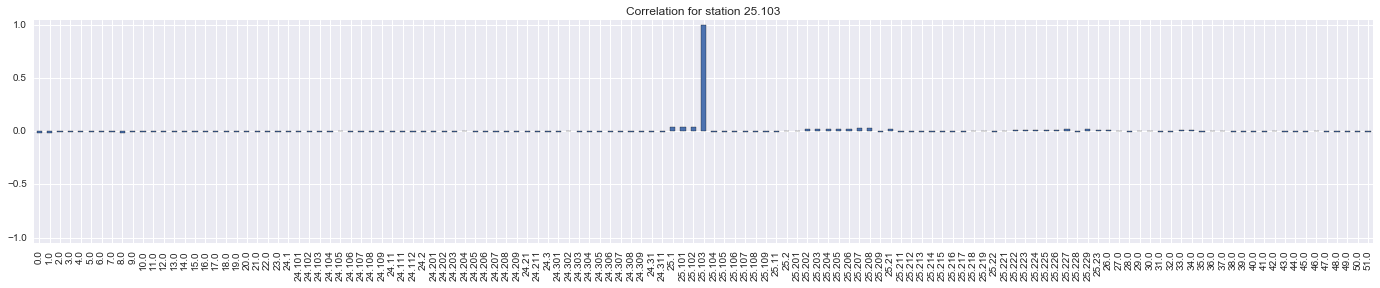

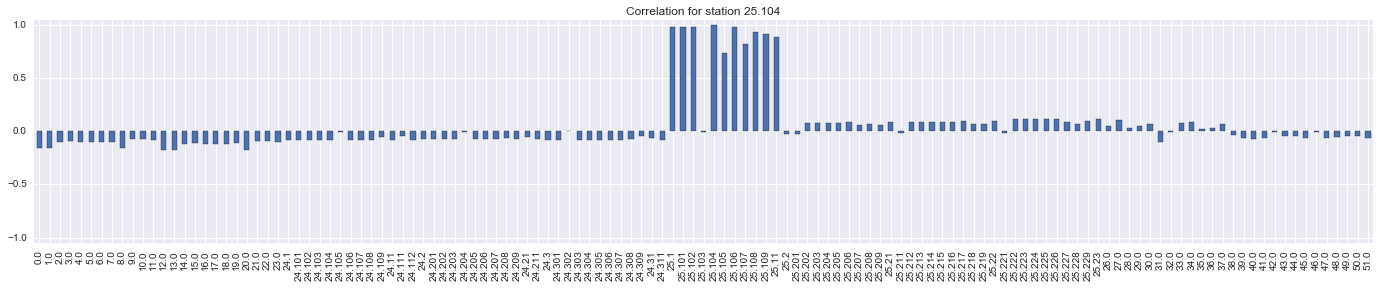

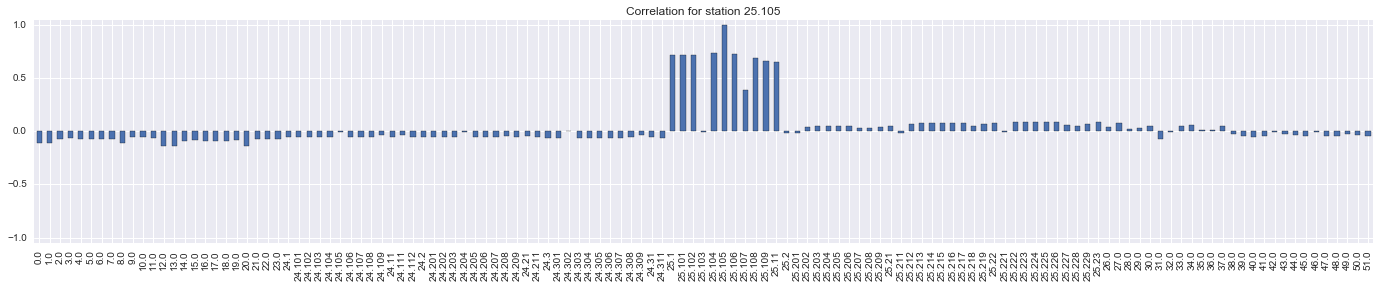

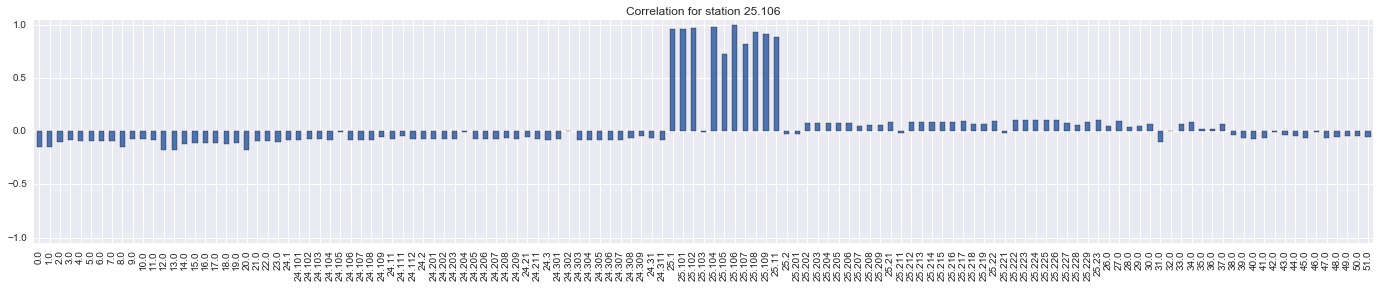

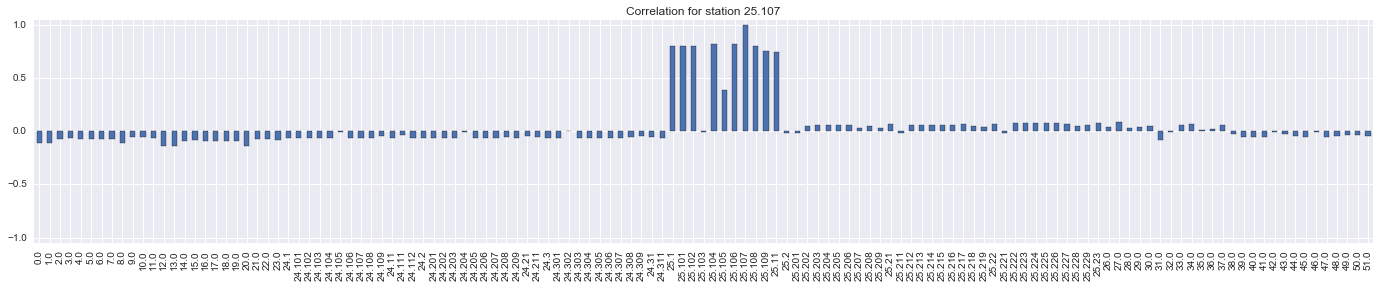

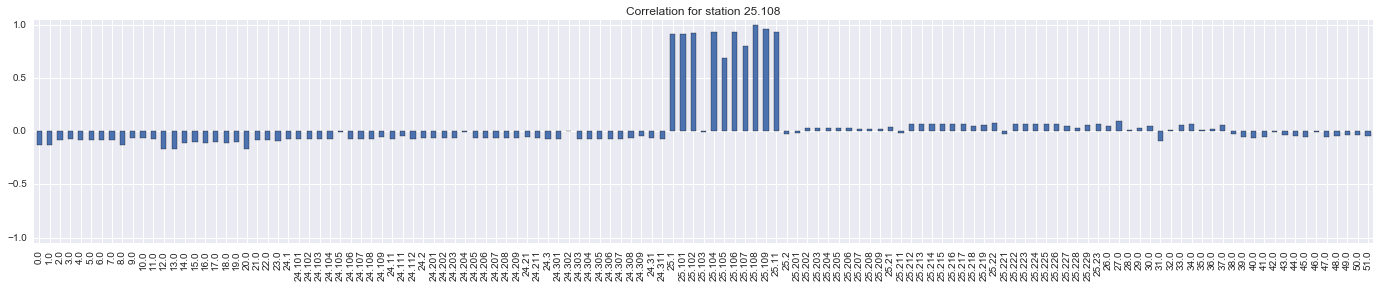

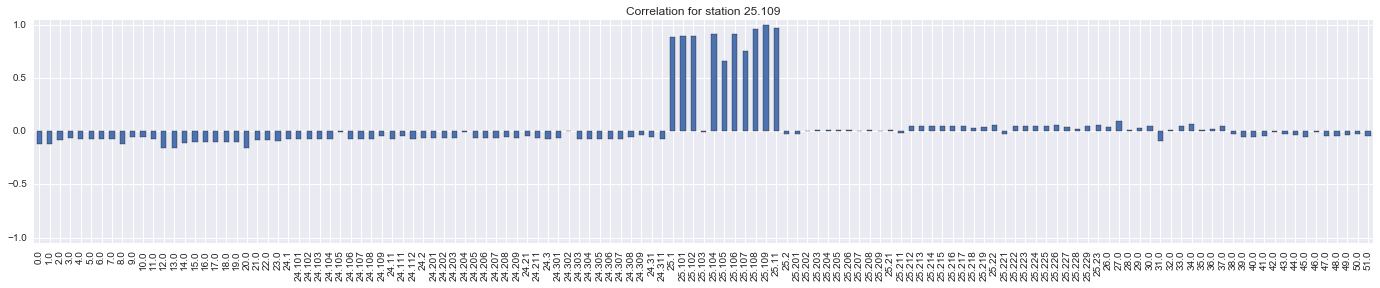

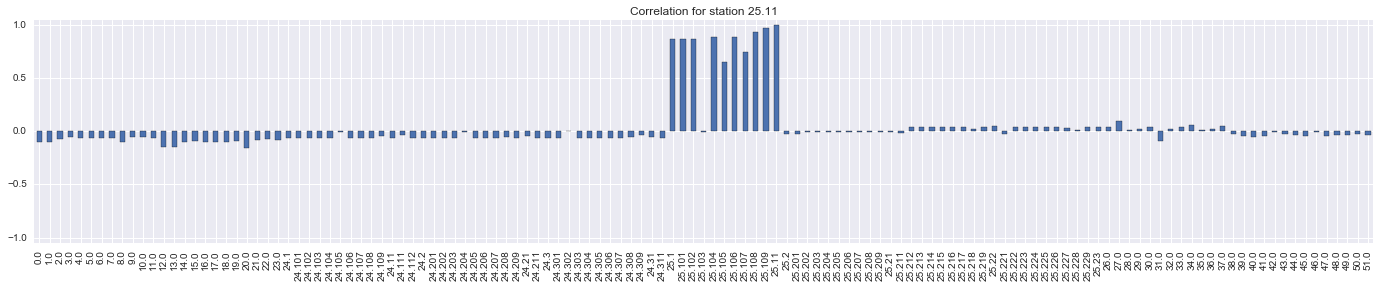

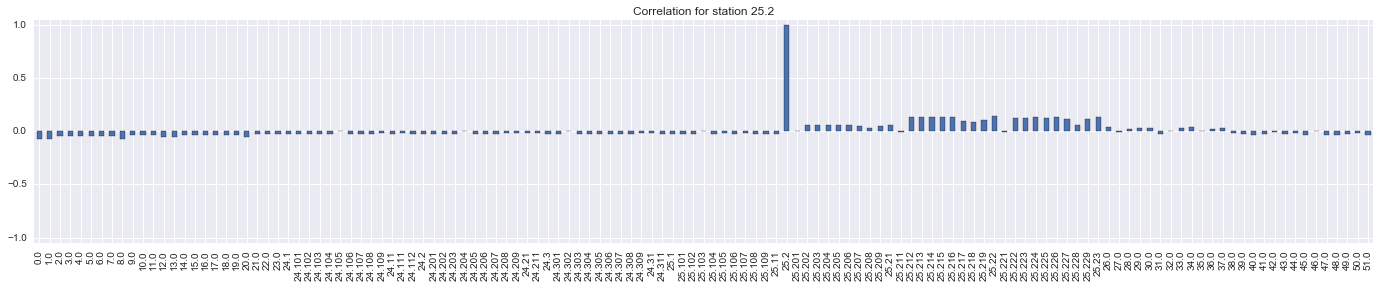

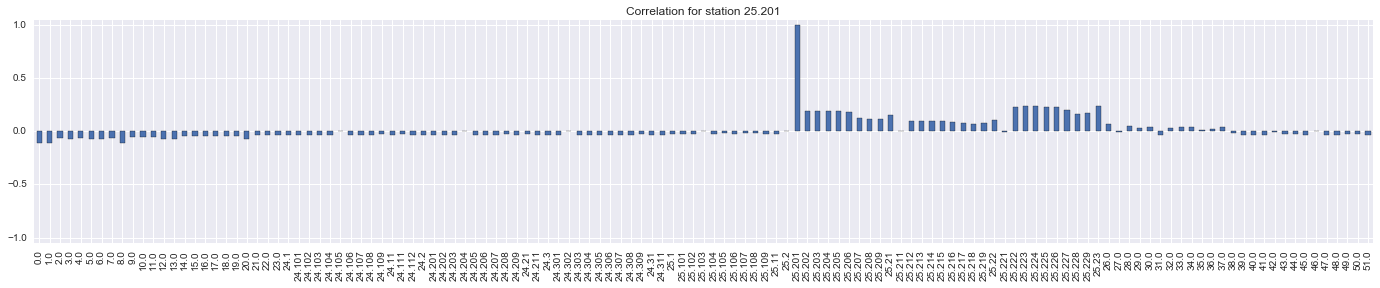

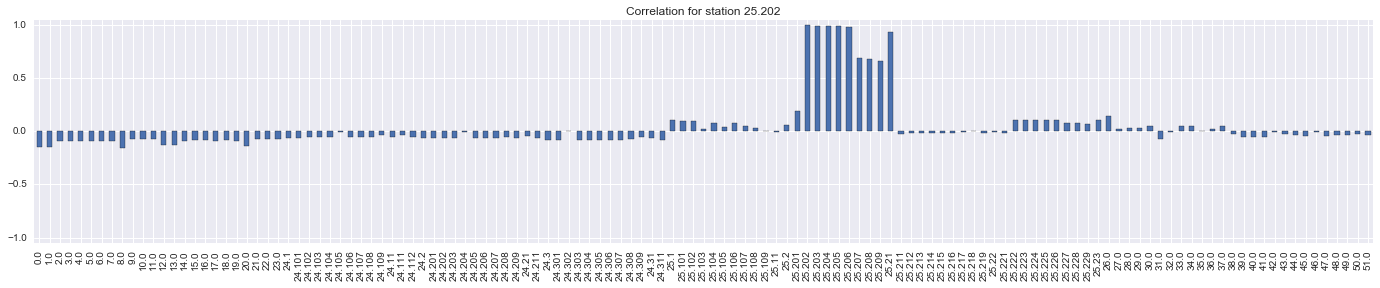

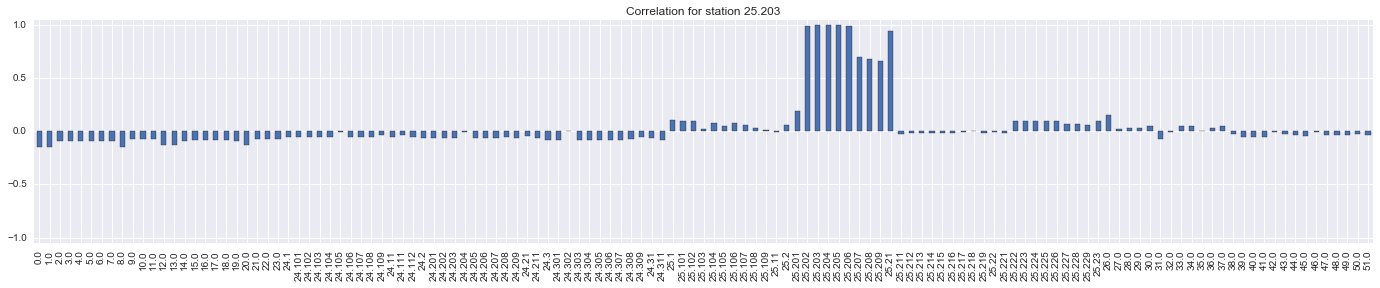

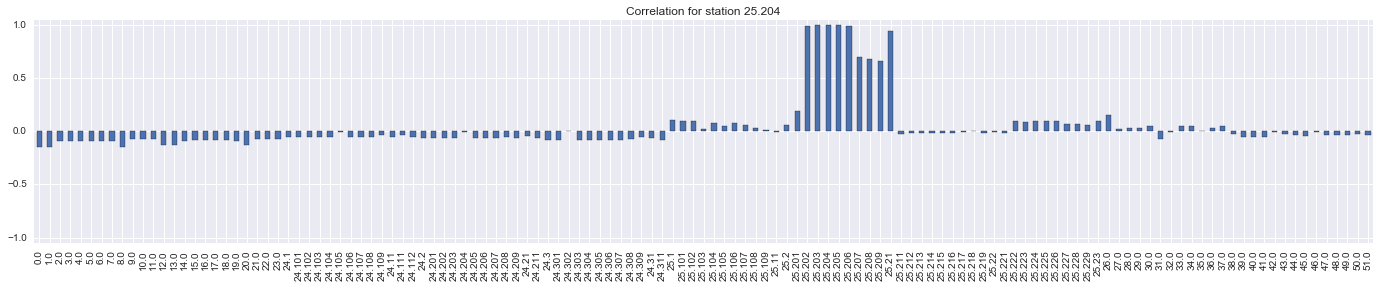

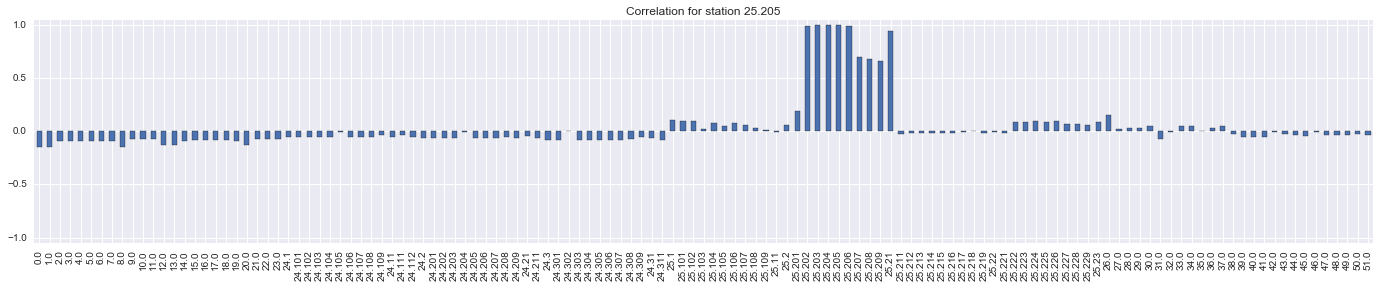

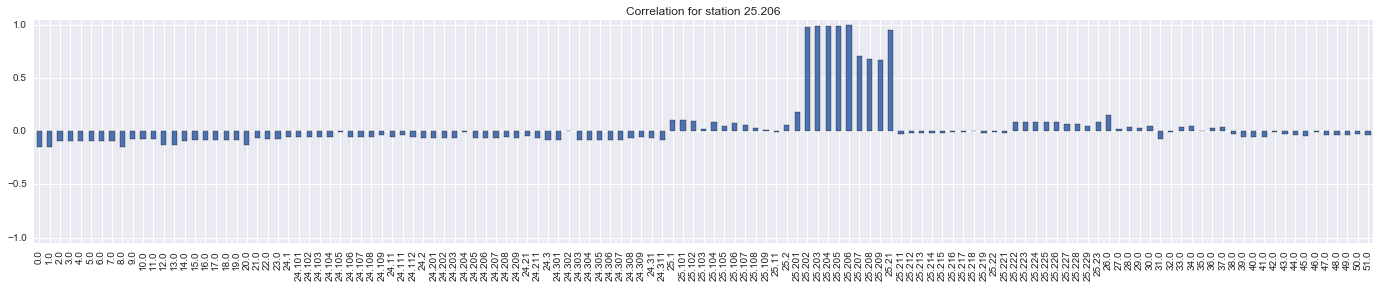

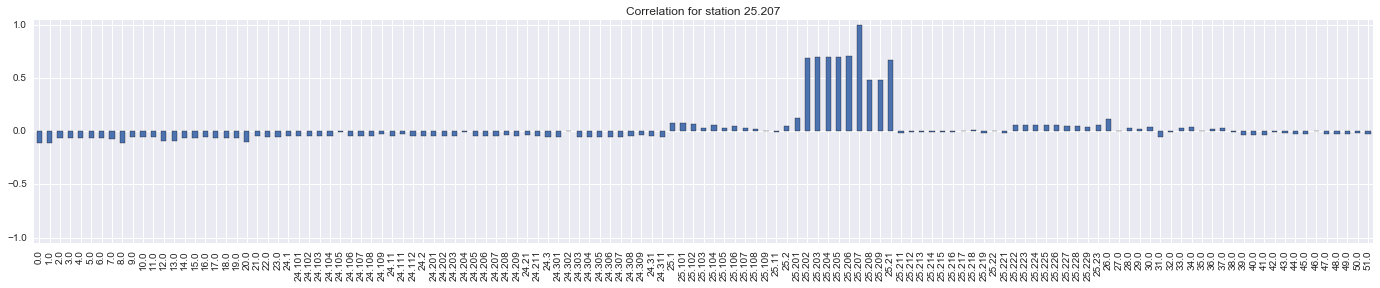

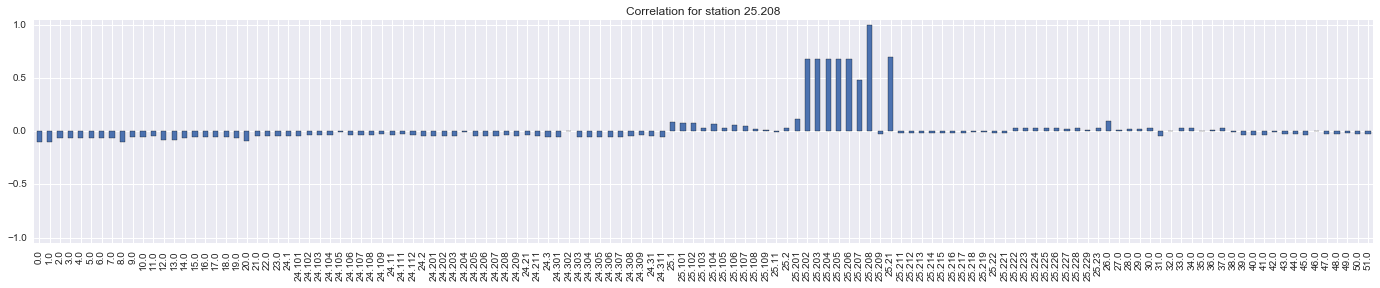

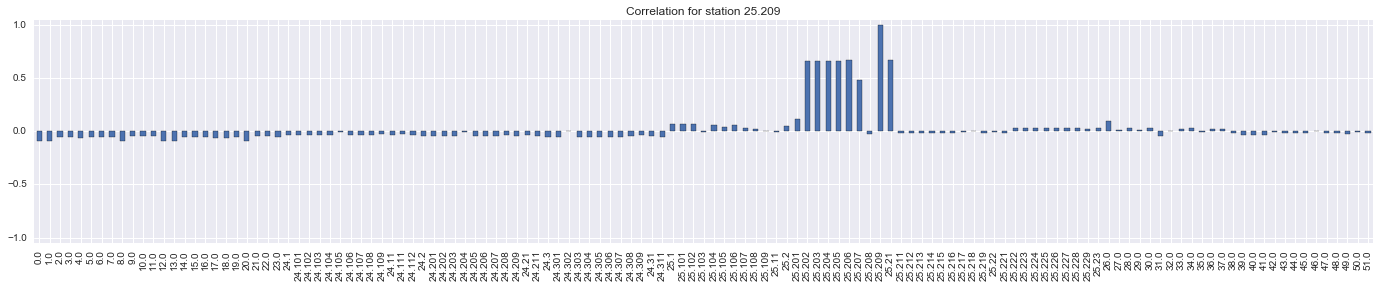

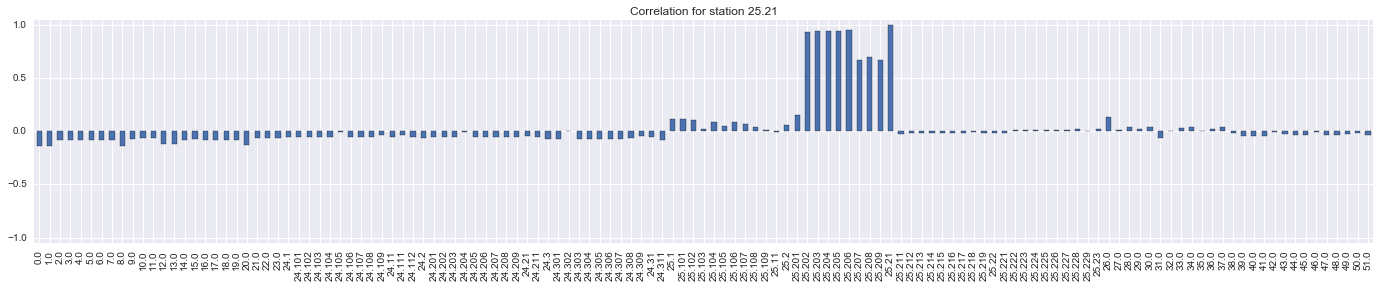

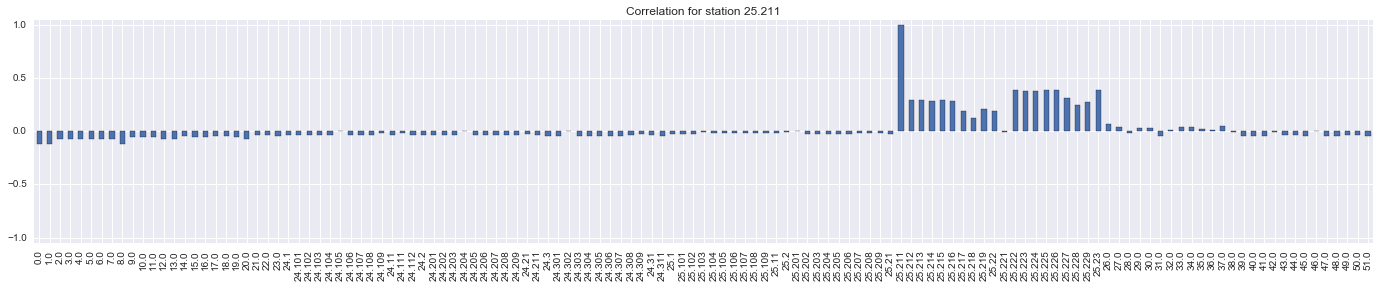

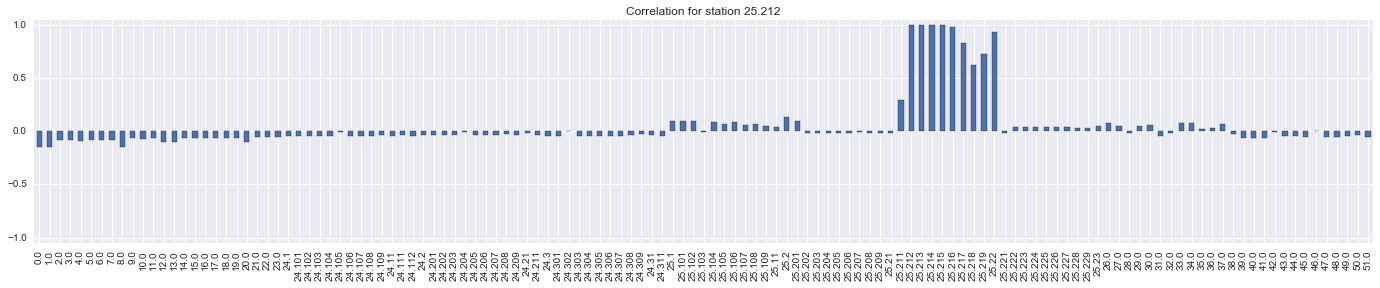

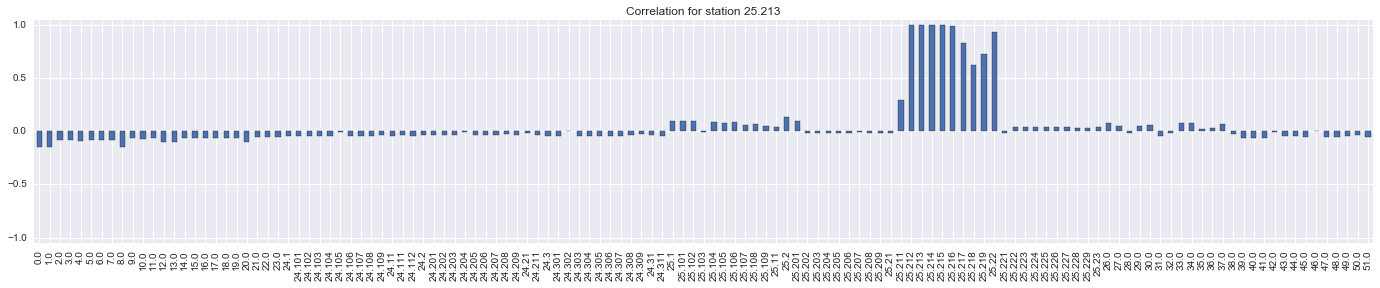

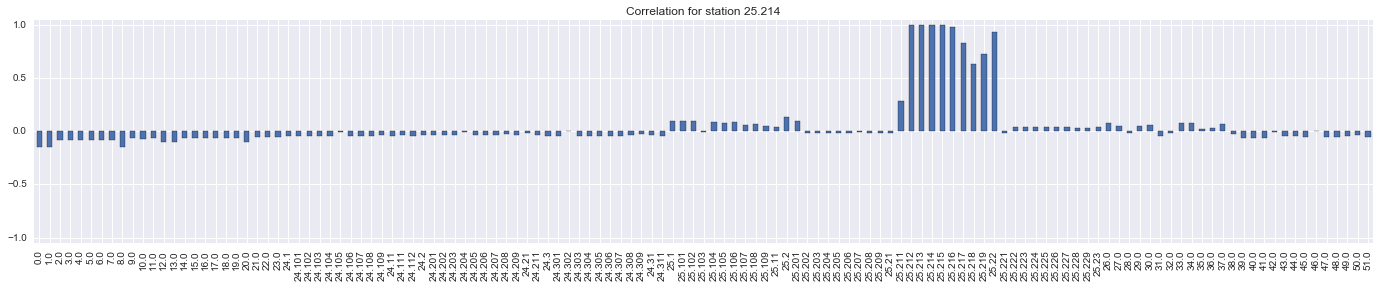

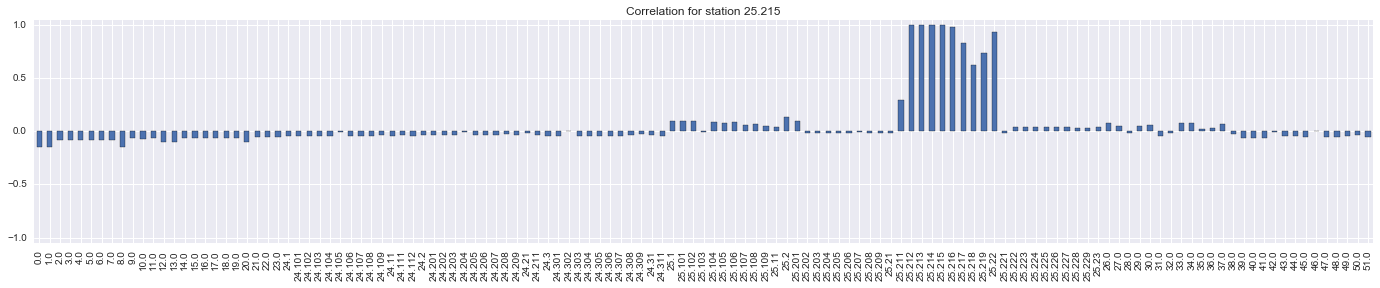

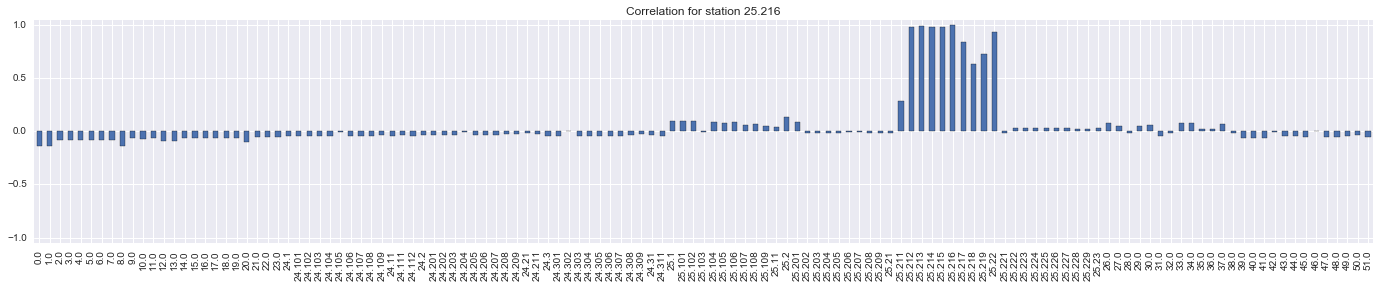

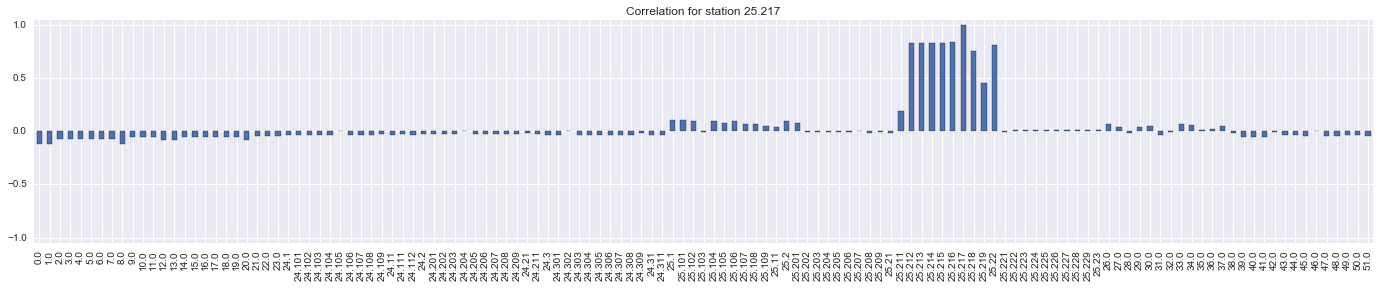

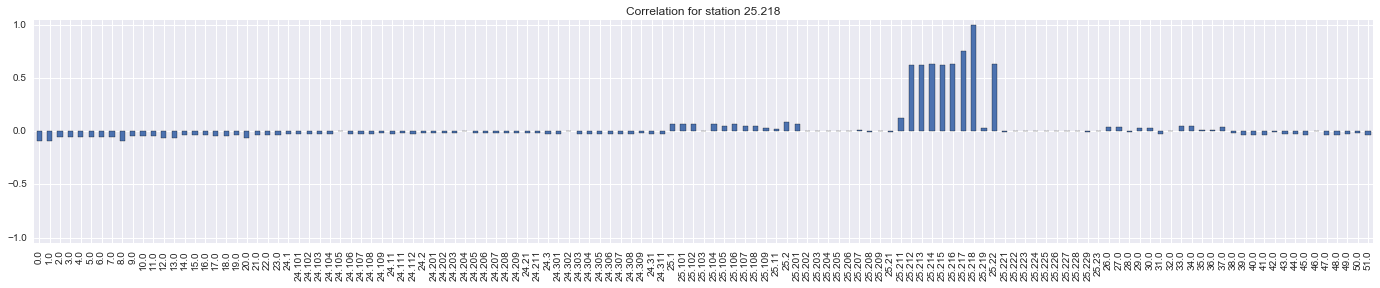

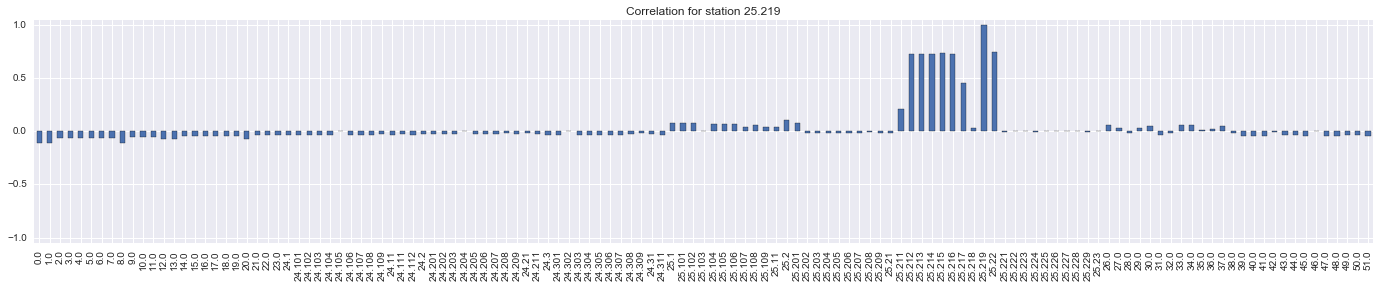

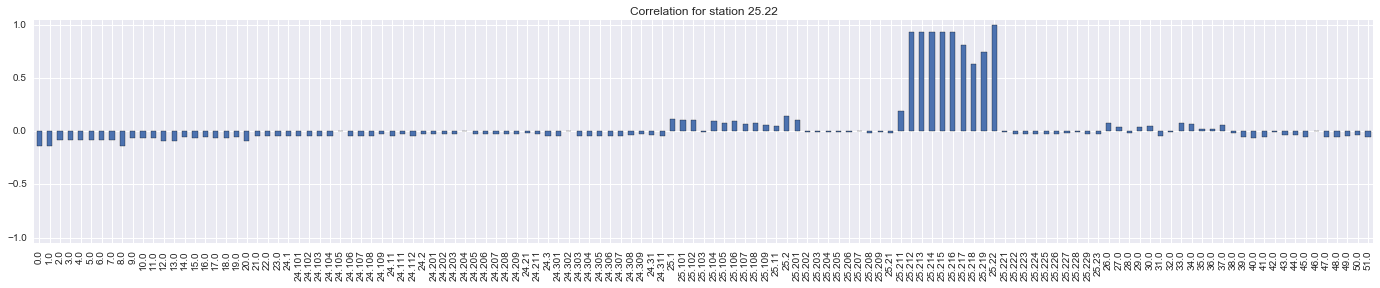

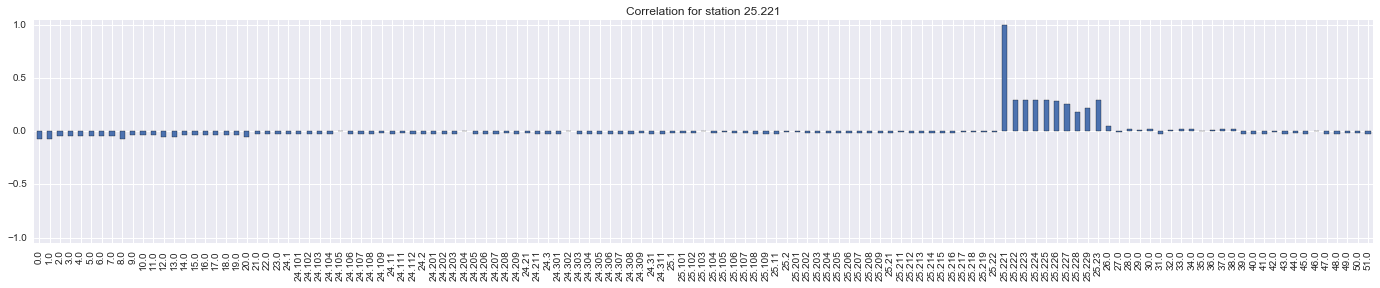

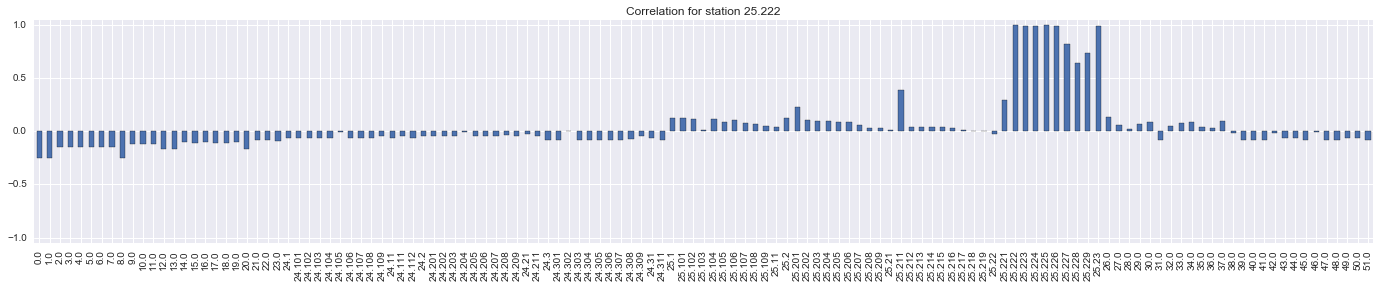

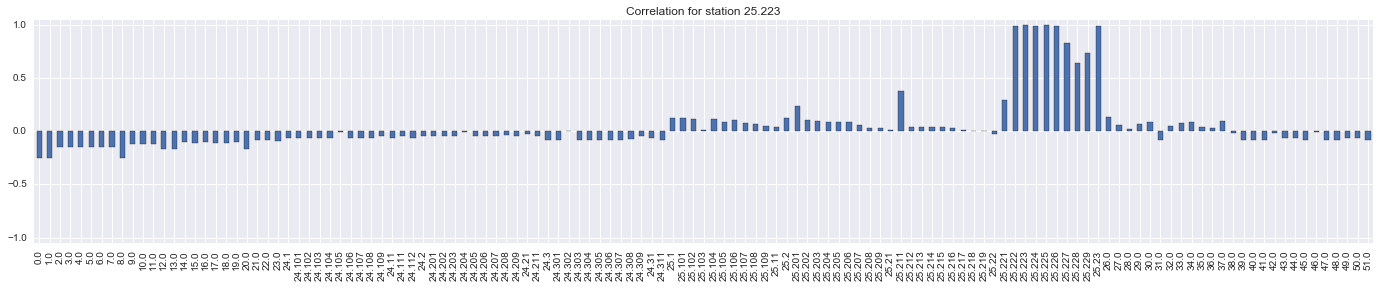

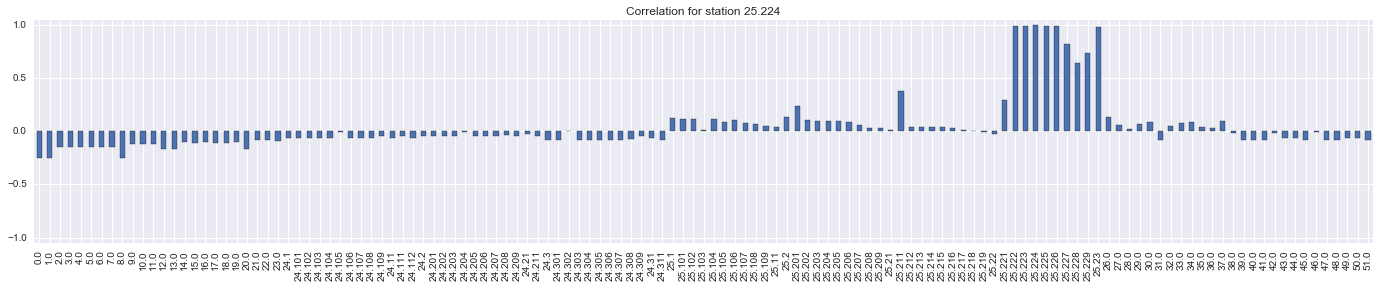

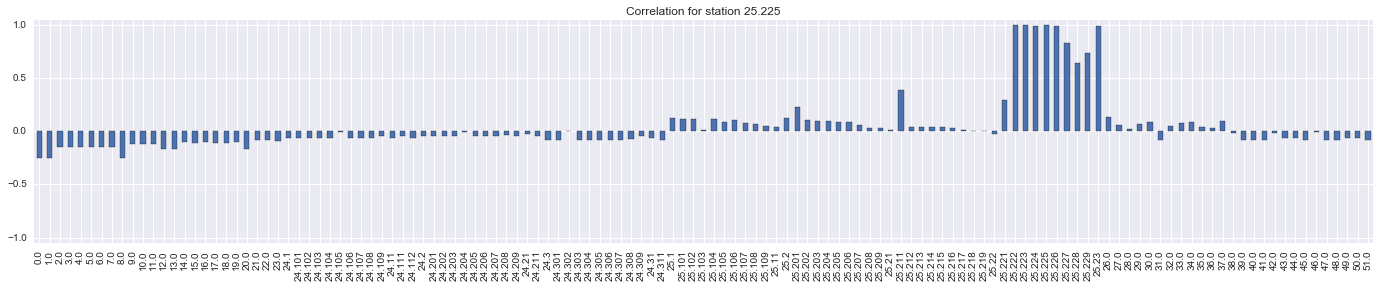

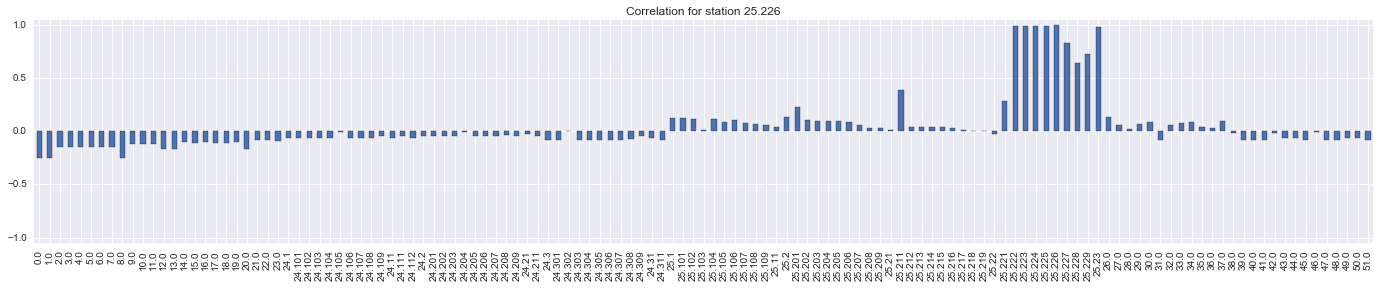

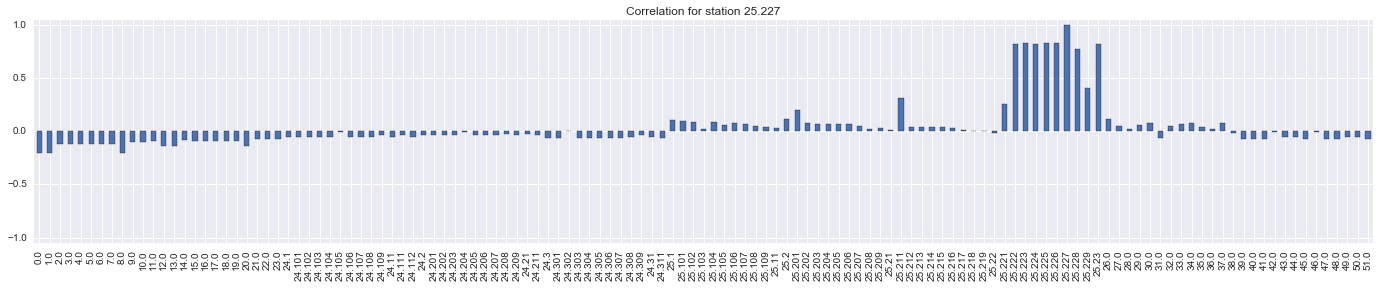

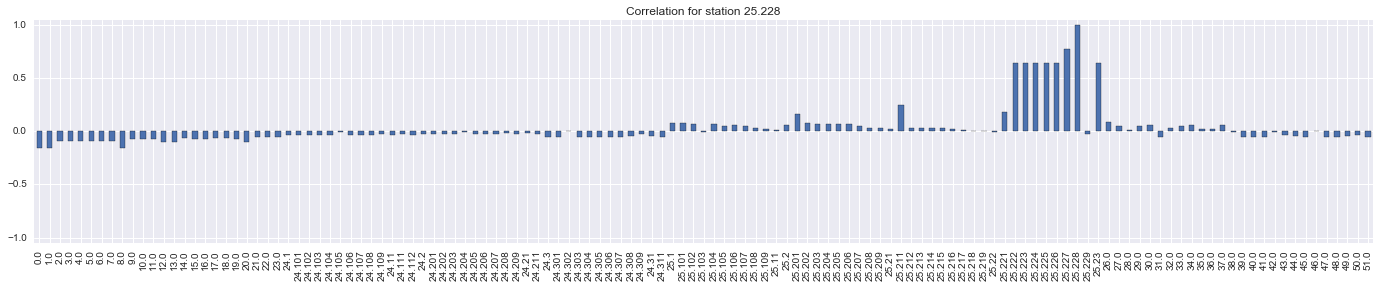

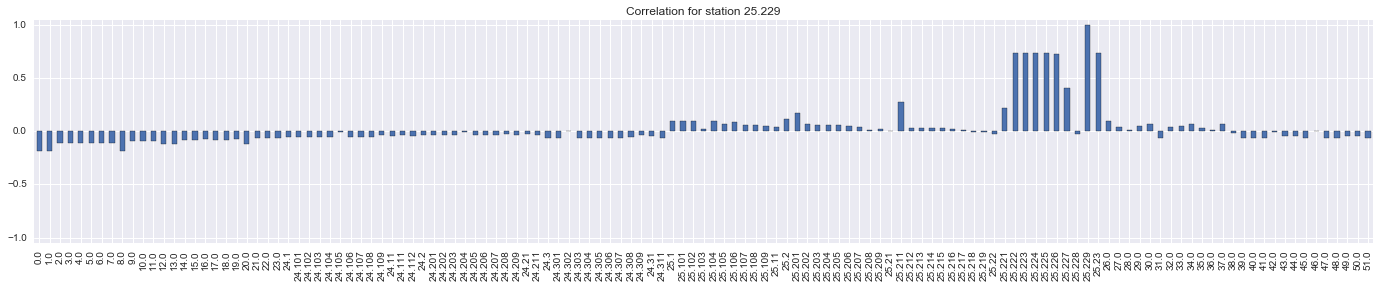

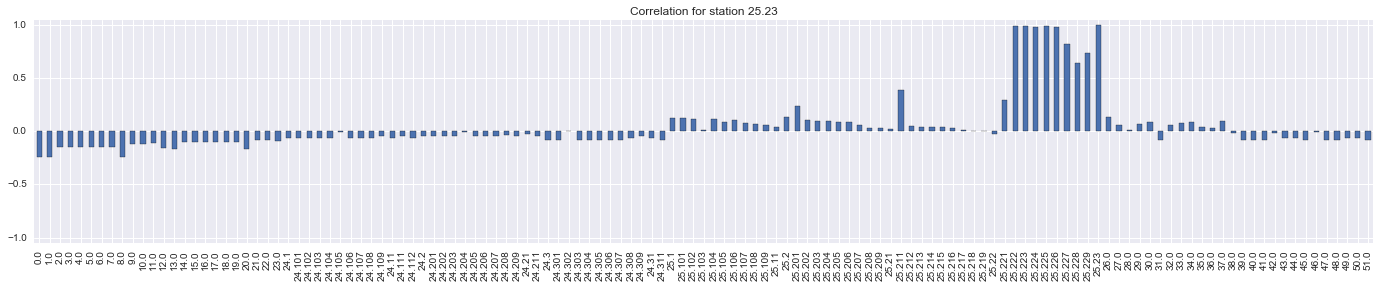

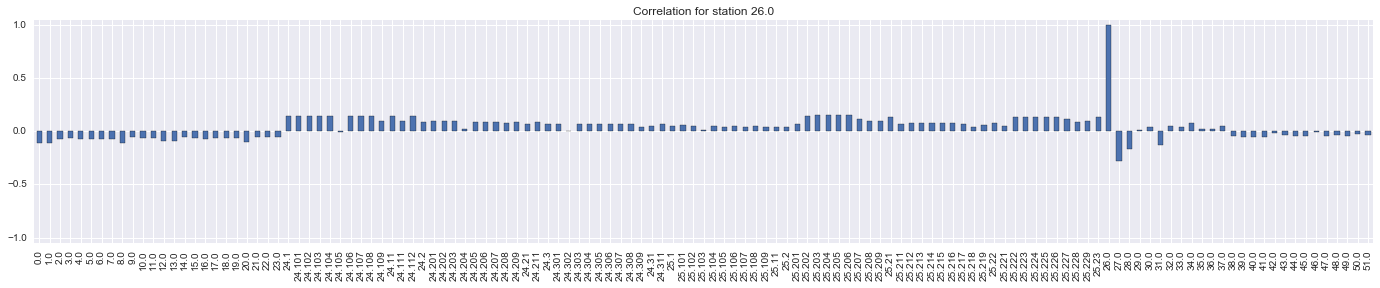

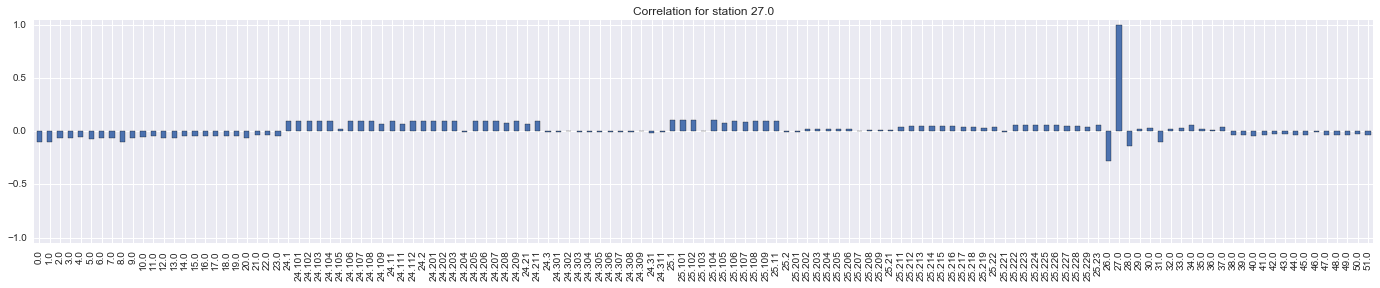

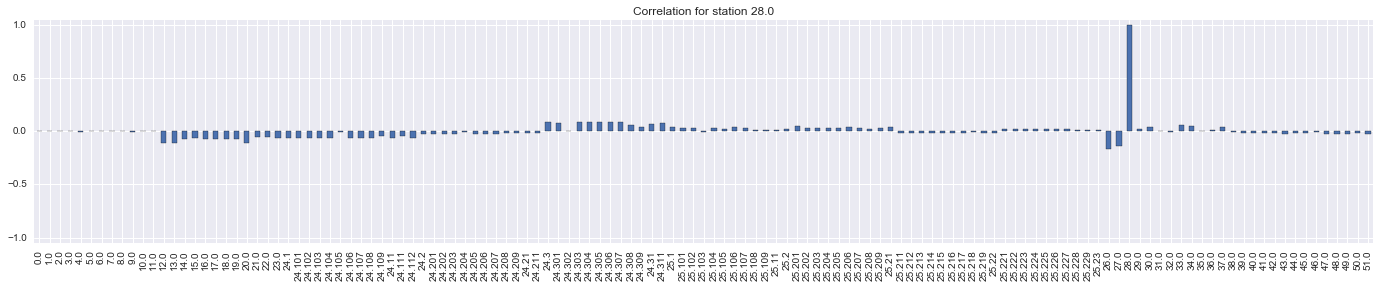

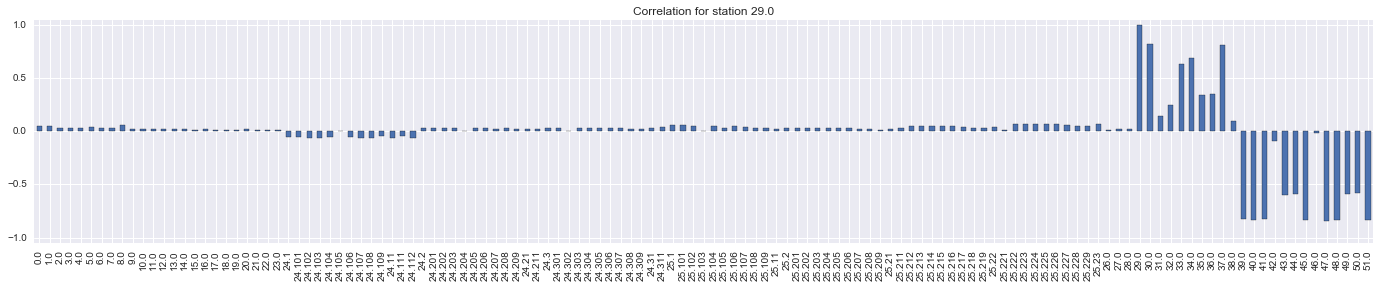

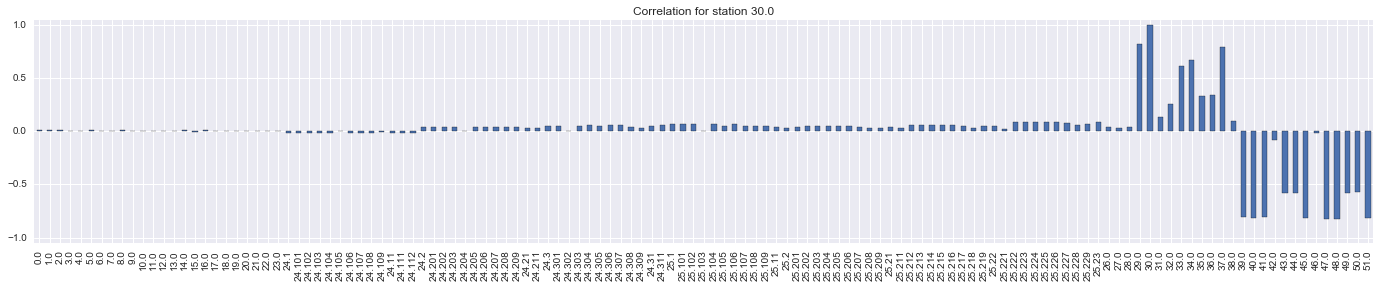

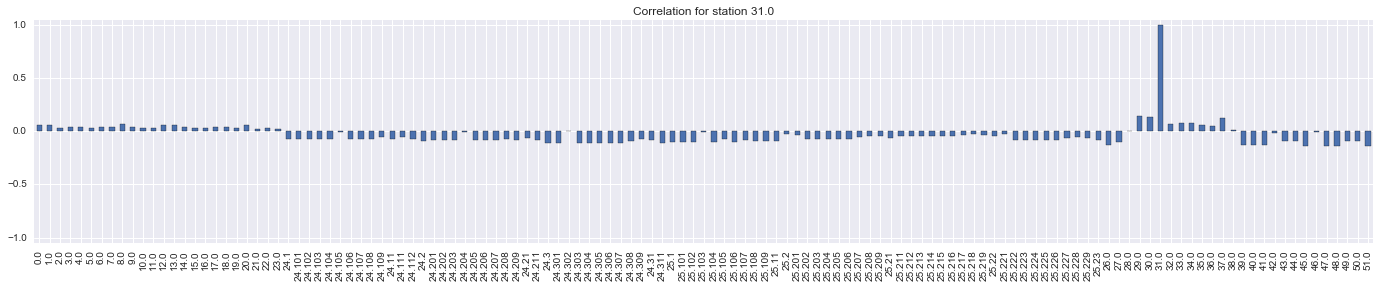

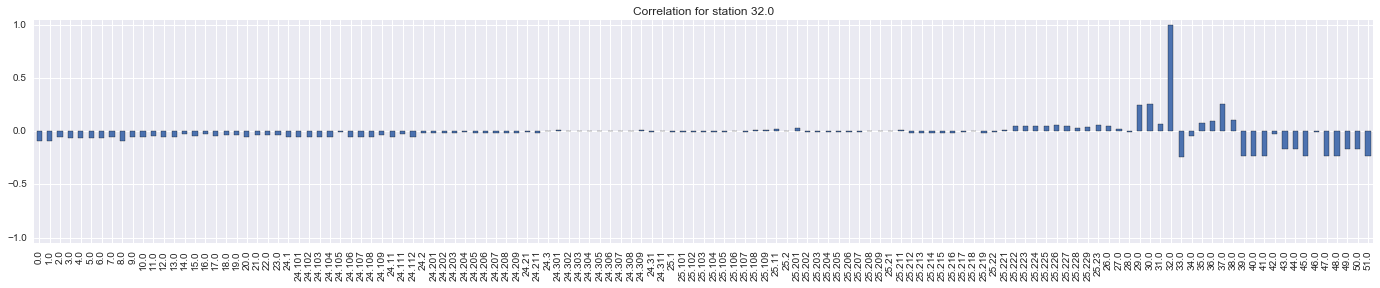

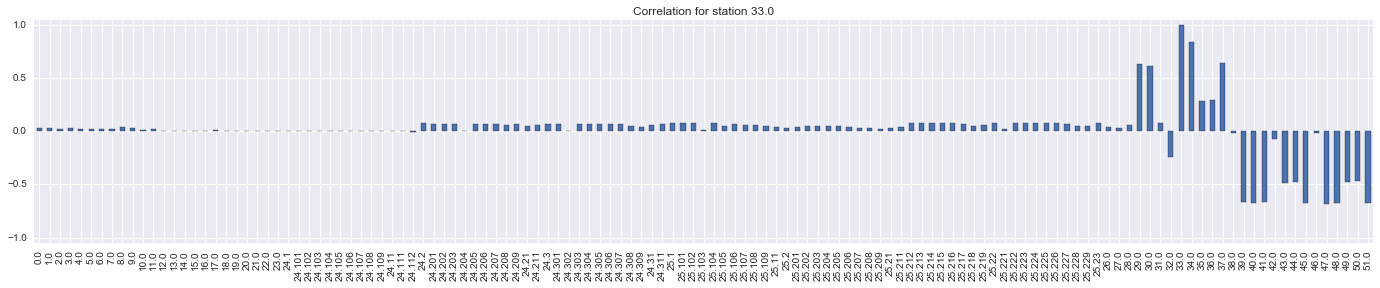

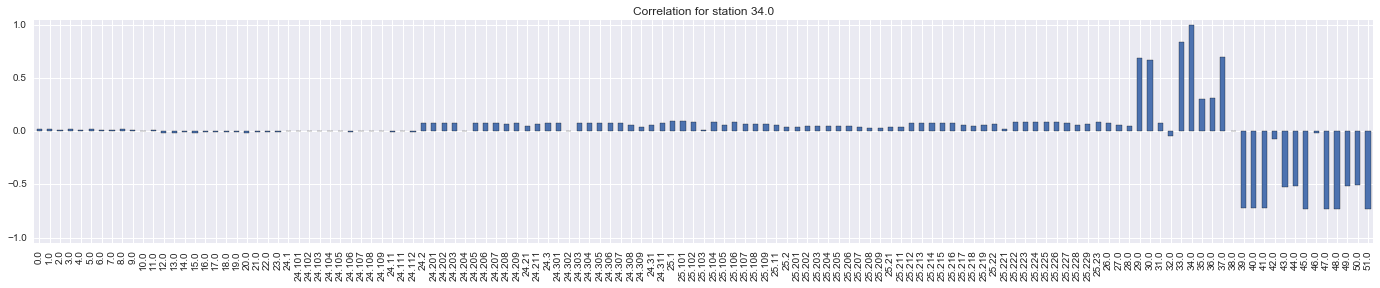

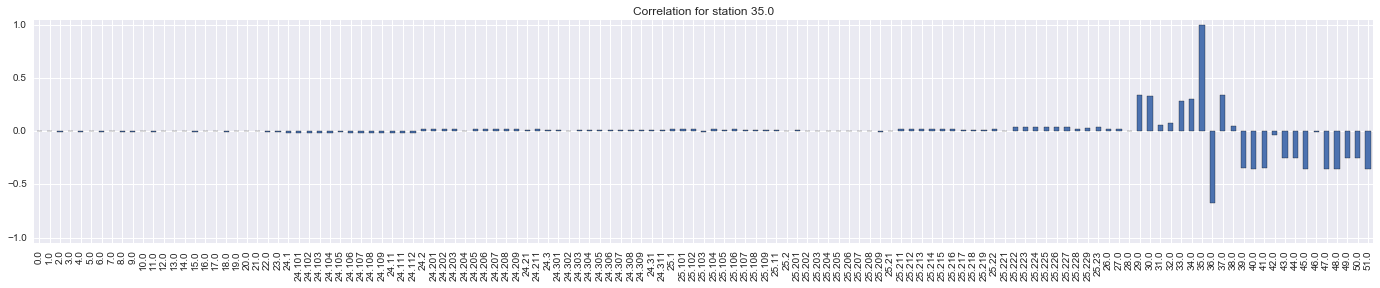

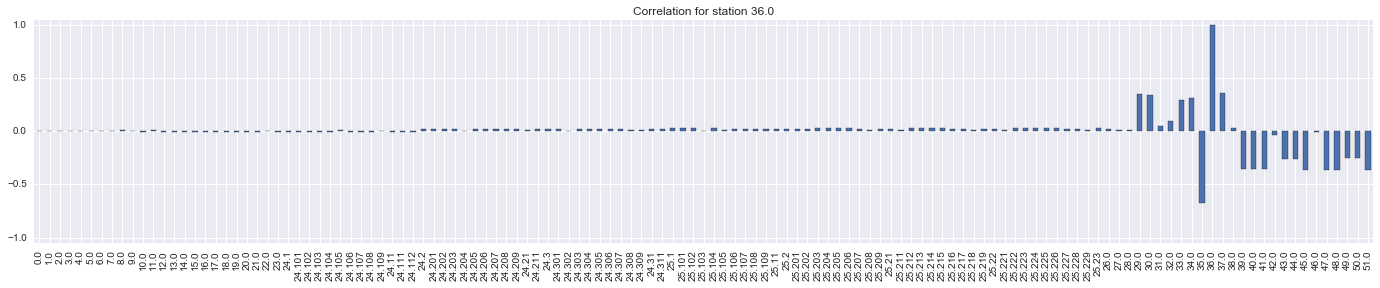

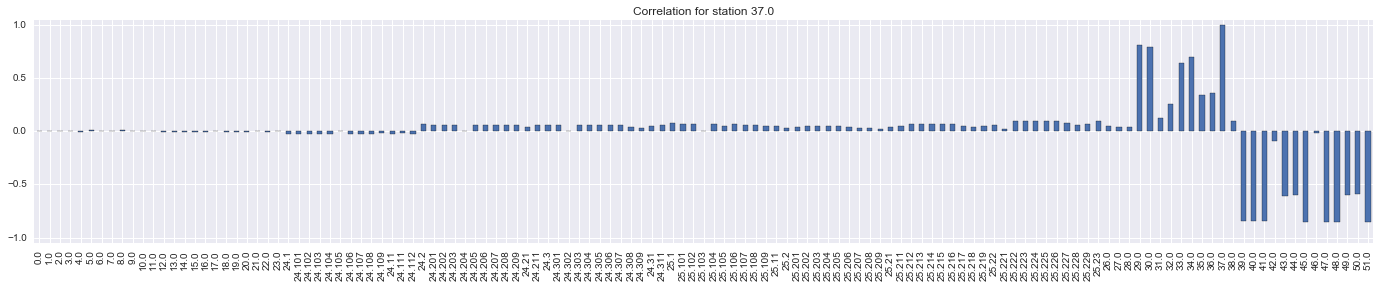

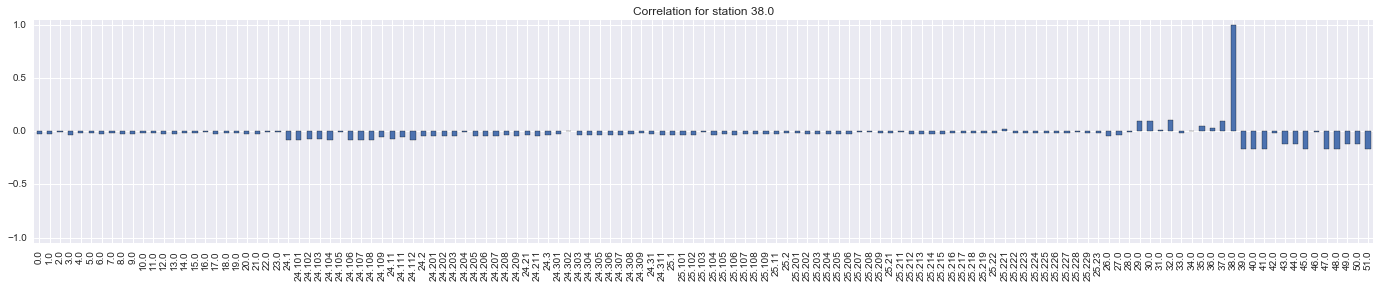

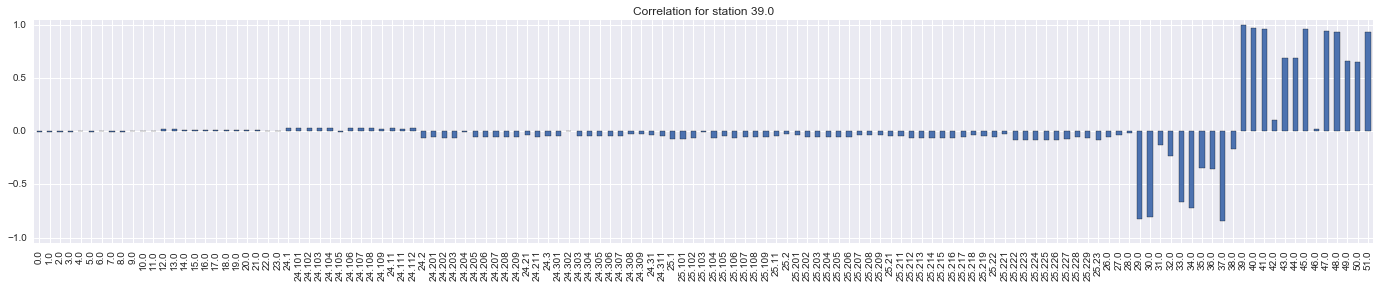

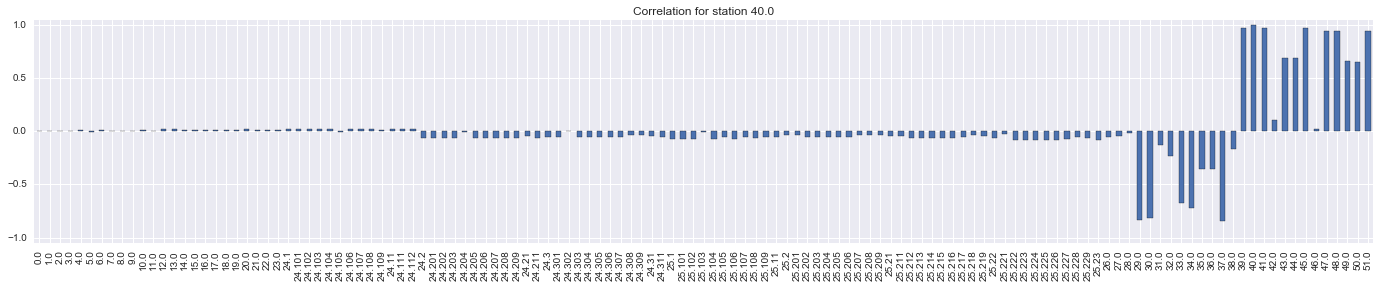

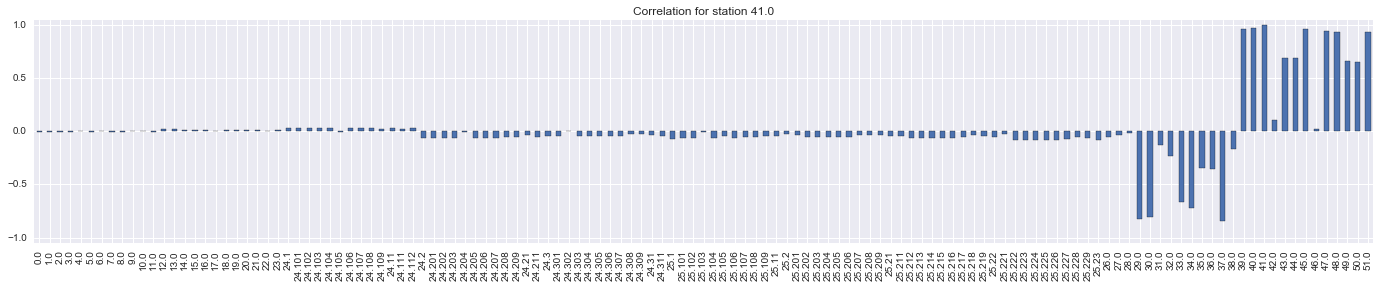

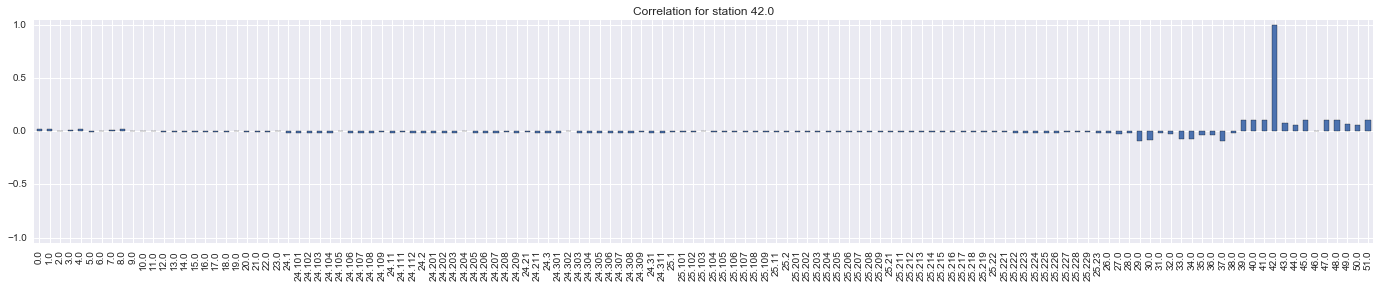

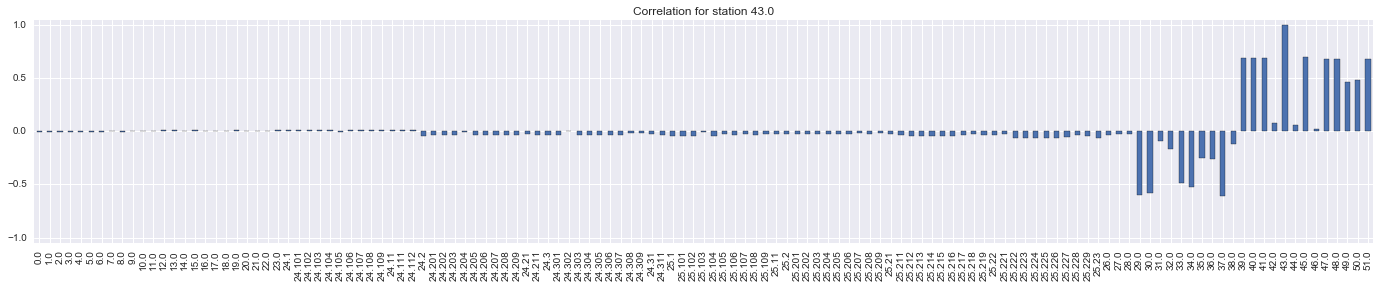

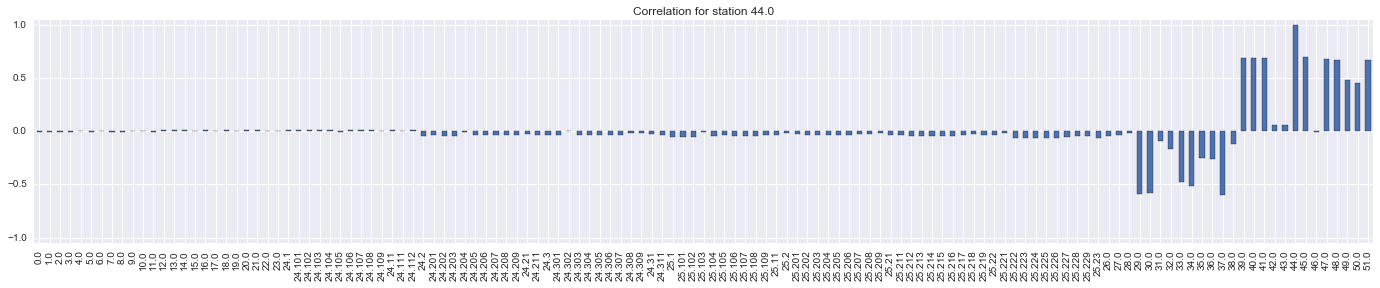

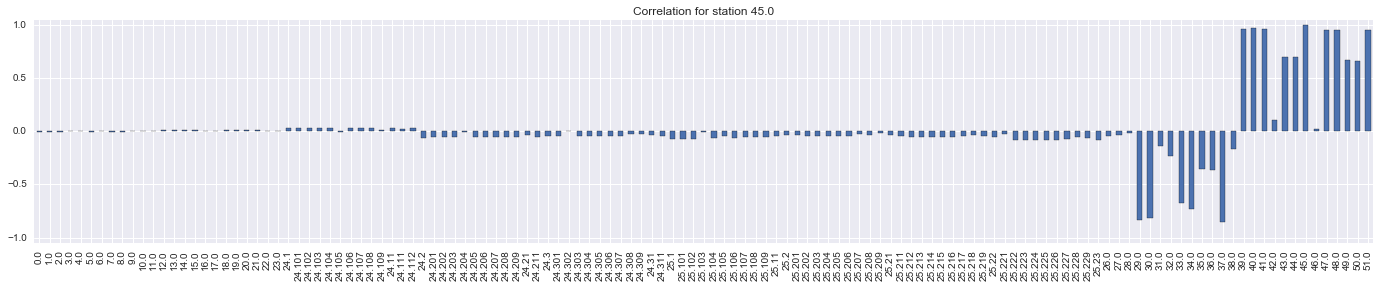

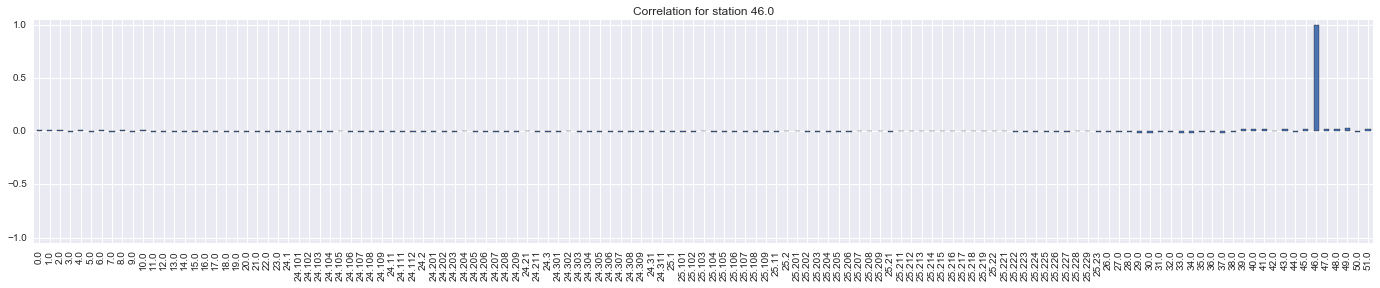

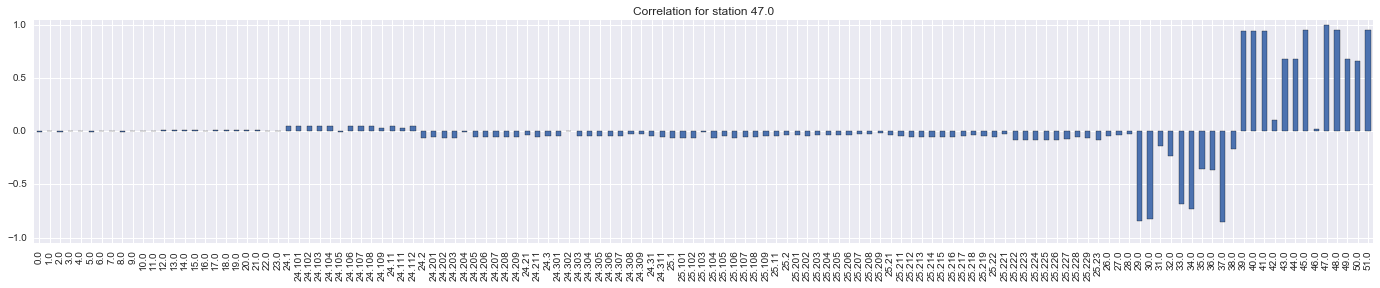

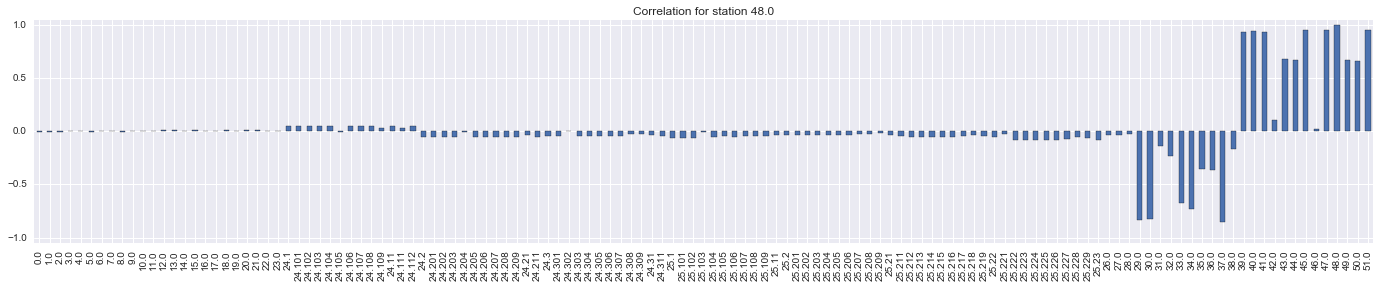

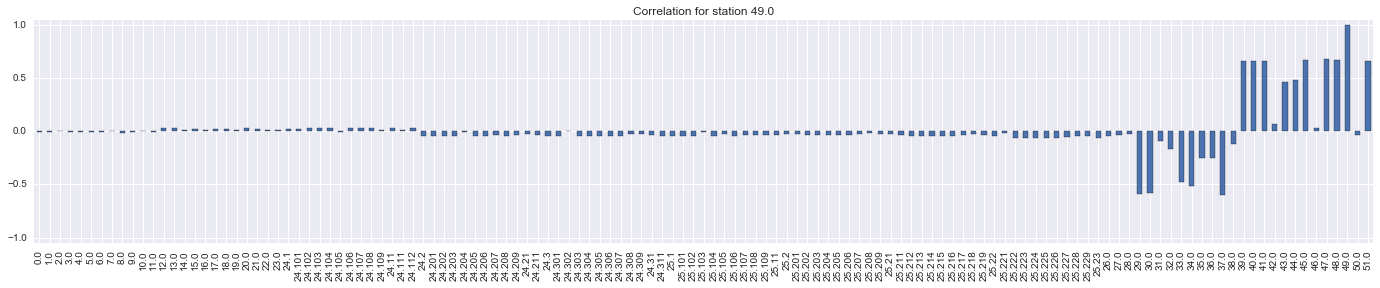

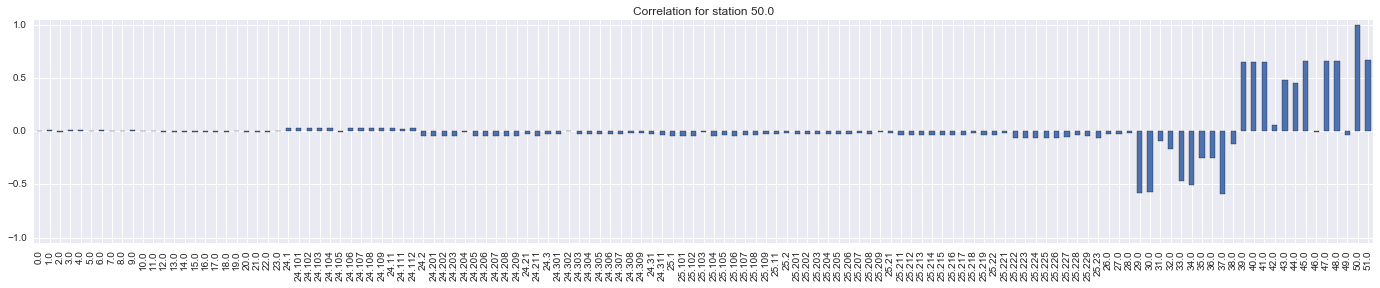

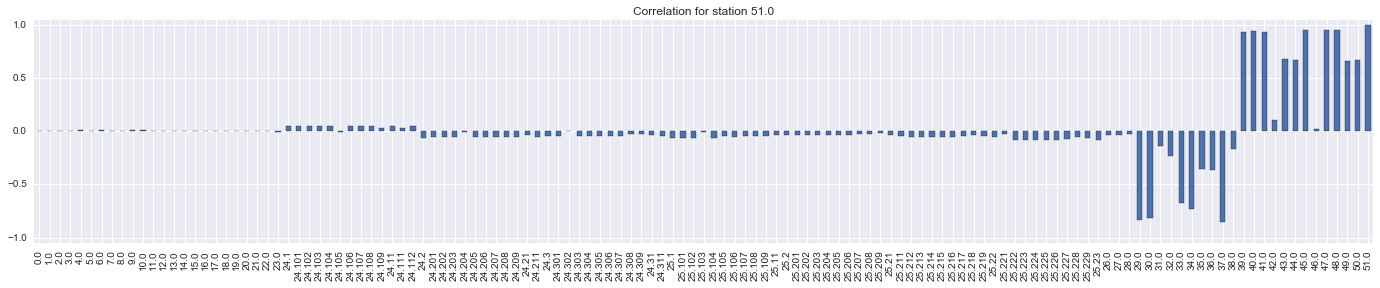

In [18]:
# Plot correlation per sample
# This takes a couple of minutes...
for i in range(corr_mat.shape[0]):
    plt.figure()
    corr_mat.iloc[:,i].plot(kind='bar', figsize=(24,4), ylim=[-1.05,1.05])
    plt.title('Correlation for station {}'.format(corr_mat.columns[i]))

In [19]:
string_id_to_pid.head()

,u_arr_ix,cluster
id,,
4,13409,1.0
6,7029,10.0
7,12763,1.0
9,13658,1.0
11,9865,1.0


In [20]:
# Analyze average coverage per cluster
average_path_cluster = paths.merge(string_id_to_pid, 
                                   left_index=True, 
                                   right_on='u_arr_ix', 
                                   how='left') \
                            .drop('u_arr_ix', axis=1) \
                            .groupby('cluster') \
                            .mean()
                        

In [21]:
average_path_cluster.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0
cluster,,,,,,,,,,,,,,,,,,,,,
1.0,0.994649,0.994564,0.500212,0.495039,0.494242,0.501341,0.500238,0.495202,0.994592,0.332847,...,0.000000,0.000048,0.000871,0.000919,0.0,0.000920,0.000922,0.000060,0.000861,0.000921
2.0,0.015101,0.015038,0.007498,0.007646,0.007900,0.007286,0.007667,0.007519,0.015186,0.005337,...,0.000000,0.001186,0.002711,0.003876,0.0,0.004405,0.004405,0.001864,0.002542,0.004405
3.0,0.000543,0.000543,0.000236,0.000307,0.000330,0.000212,0.000378,0.000165,0.000543,0.000212,...,0.000000,0.000189,0.001605,0.001794,0.0,0.001817,0.001817,0.000260,0.001558,0.001817
4.0,0.998667,1.000000,0.491333,0.500000,0.495333,0.498667,0.489333,0.505333,0.994000,0.335333,...,0.000000,0.012667,0.032667,0.044667,0.0,0.045333,0.045333,0.024667,0.020667,0.045333
5.0,0.001019,0.001019,0.000538,0.000481,0.000538,0.000481,0.000311,0.000708,0.001019,0.000283,...,0.000226,0.479136,0.463000,0.935341,0.0,0.935200,0.934775,0.463226,0.473446,0.929481


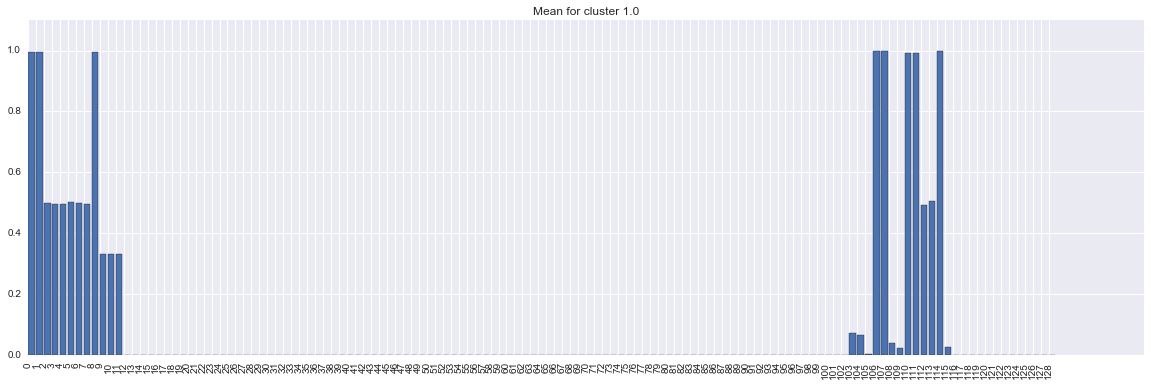

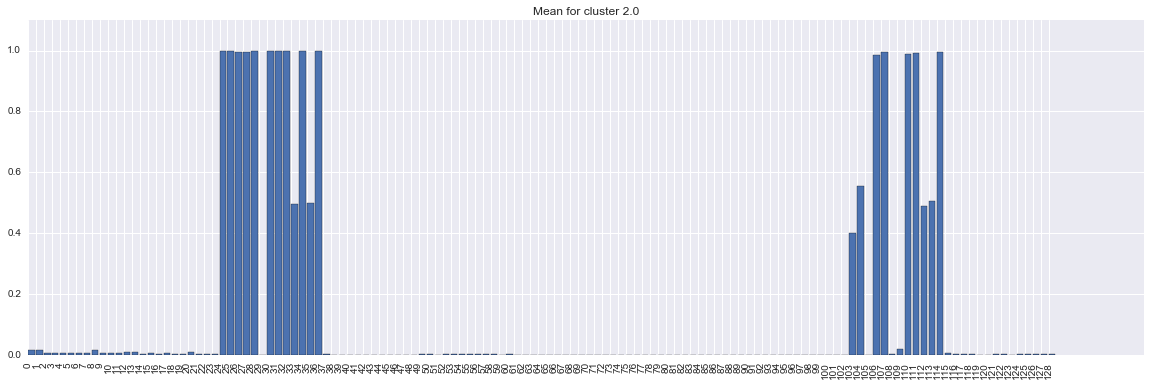

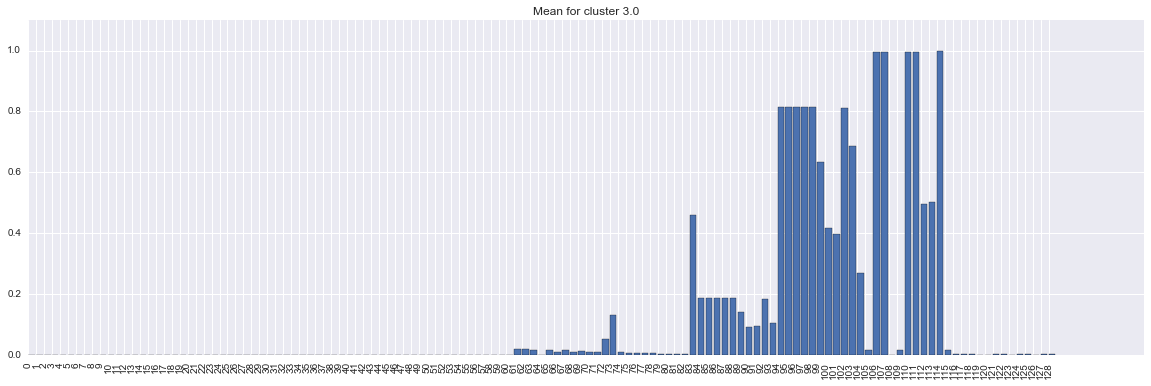

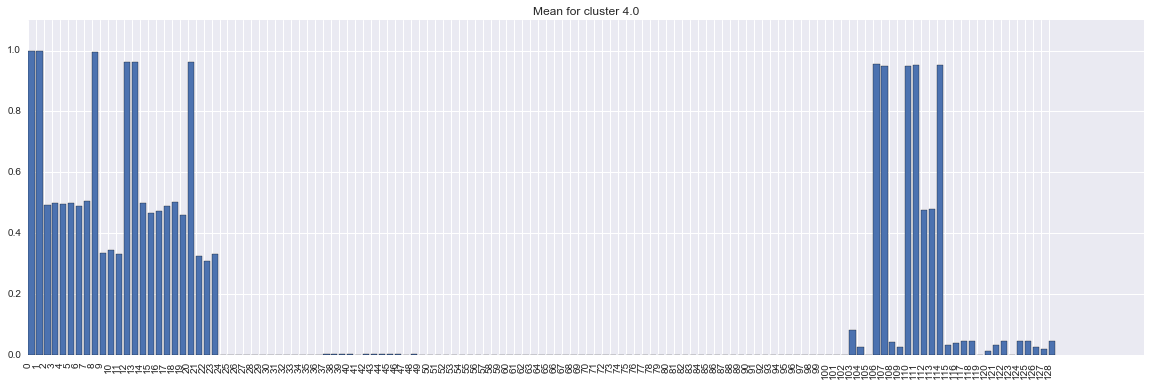

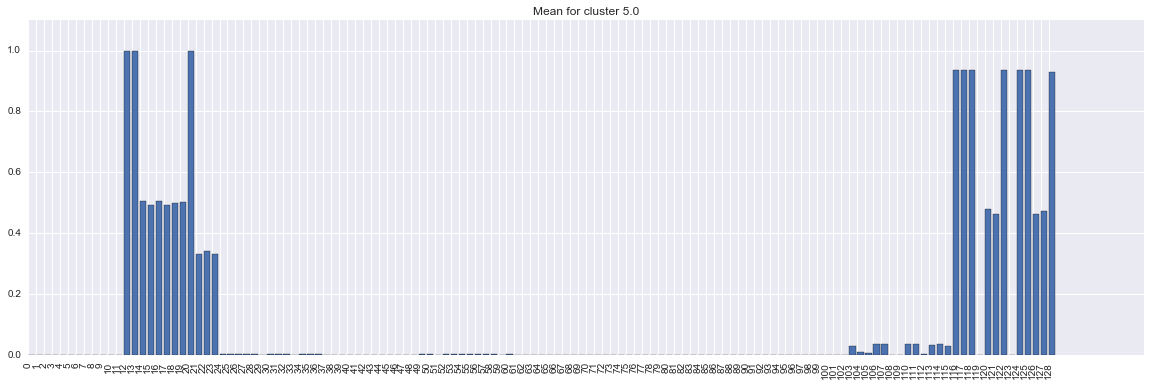

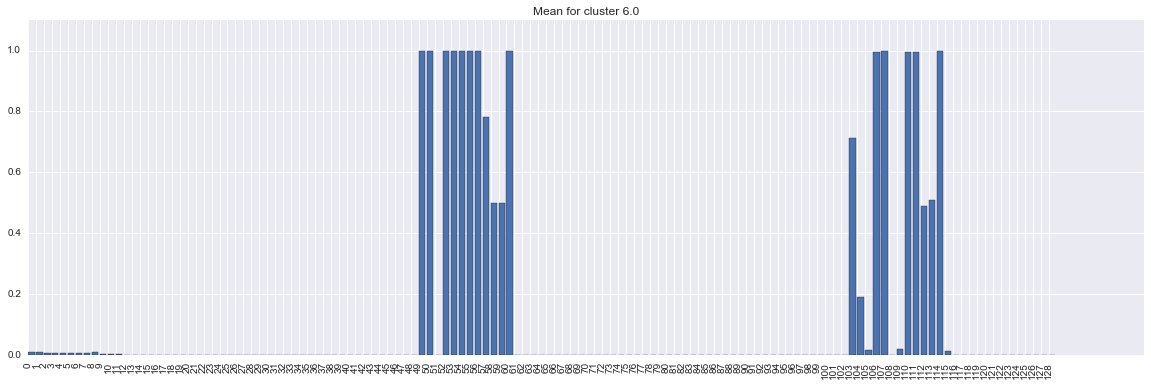

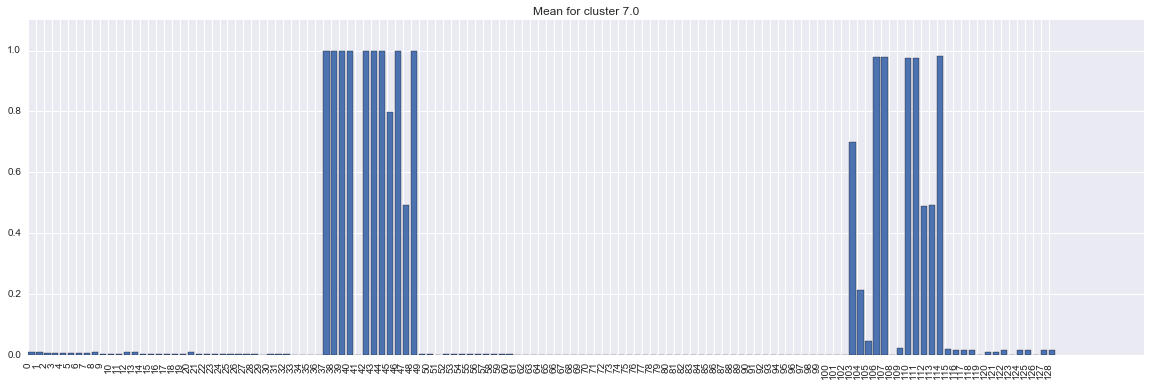

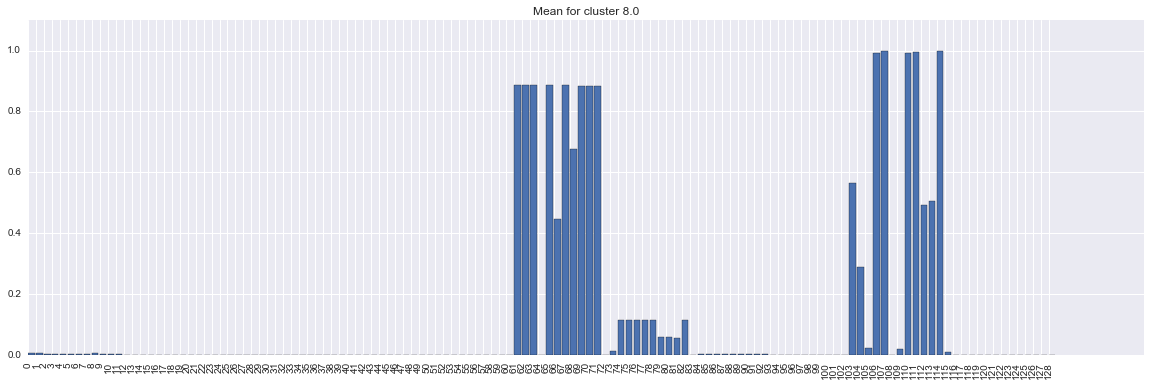

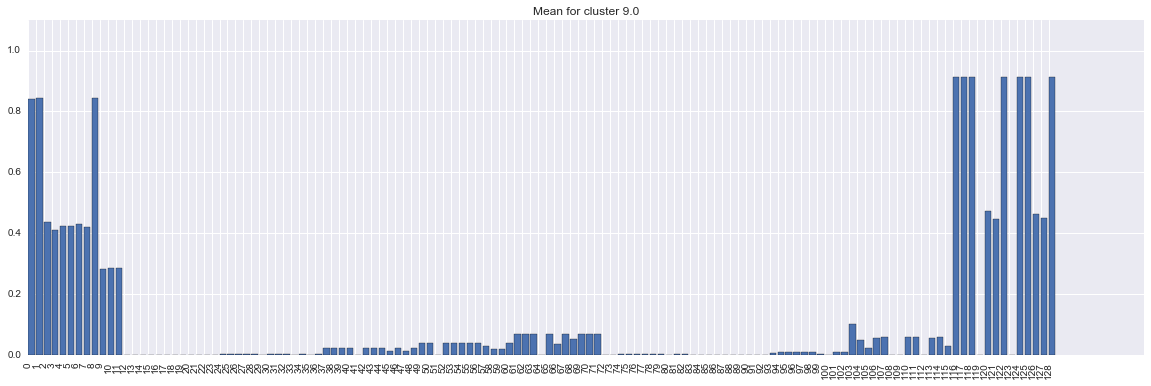

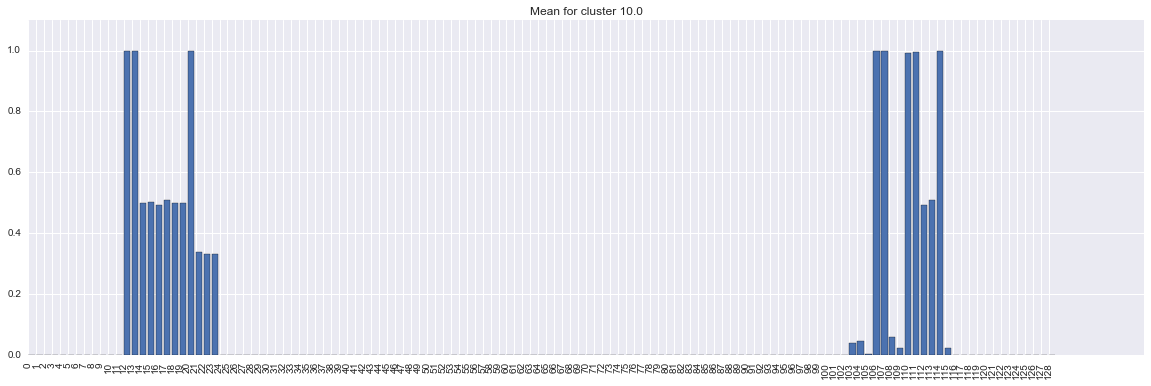

In [22]:
for i in average_path_cluster.index:
    plt.figure()
    mns = average_path_cluster.loc[i]
    plt.figure(figsize=(20,6))
    plt.bar(range(129), mns)
    plt.ylim([0,1.1])
    plt.xticks(range(129), label=average_path_cluster.columns, rotation='vertical')
    plt.title('Mean for cluster {}'.format(corr_mat.columns[i]))

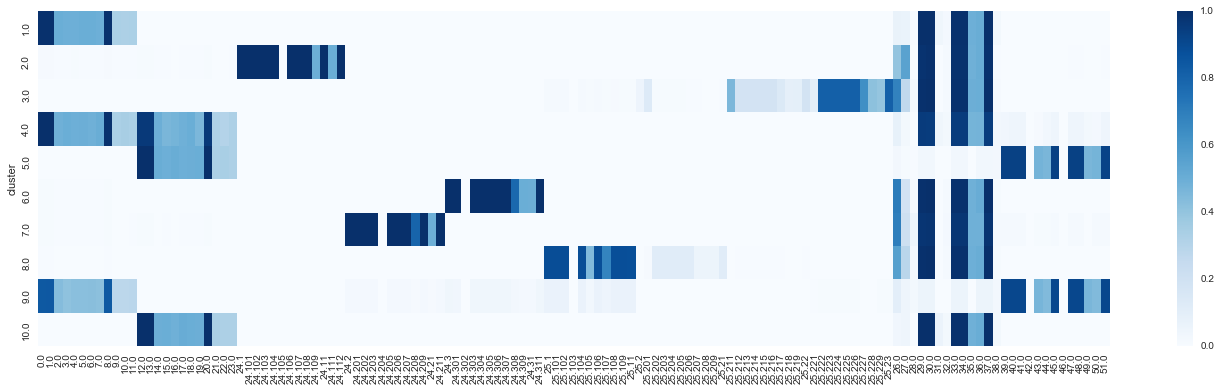

In [23]:
# in 2d image
plt.figure(figsize=(24,6))
sns.heatmap(average_path_cluster, cmap='Blues')

### Calculate deviation from cluster path for each sample

In [86]:
def calculate_path_diff(path_1, path_2):
    return np.count_nonzero( path_1 != path_2 )

def calculate_sample_path_diff_cluster(sample, paths_lut, average_path_cluster):
    if sample['cluster']==0:
        return -1
    
    path_cluster = average_path_cluster.loc[sample['cluster']]>0.495
    
    path_sample = paths_lut.loc[sample['u_arr_ix']]
    
    return calculate_path_diff(path_cluster, path_sample)

In [87]:
path_dev = sample_info.apply(lambda x: calculate_sample_path_diff_cluster(x, paths, average_path_cluster), axis=1)

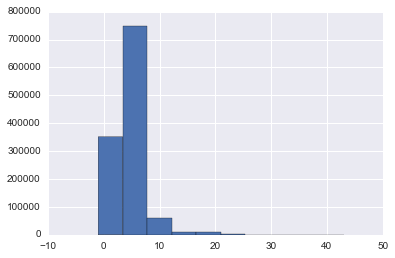

In [88]:
path_dev.hist()

In [32]:
sample_info.head()

,first_station,last_station,min,max,count,delta_max,n_max,Response_x,u_arr_ix,cluster,...,n_categorical_t,n_numeric,n_numeric_t,n_timestamp,n_unknown,sample_nr,t_max,t_min,Response_y,t_delta
Id,,,,,,,,,,,,,,,,,,,,,
4,0.0,113.0,0.0,5.05,14,4.99,105.0,0,13409,1.0,...,83.0,162.0,91.0,179.0,5.0,0.0,87.290001,82.239998,0,5.050003
6,12.0,113.0,0.0,2.63,13,2.58,105.0,0,7029,10.0,...,116.0,192.0,90.0,209.0,3.0,1.0,1315.750000,1313.119995,0,2.630005
7,0.0,113.0,0.0,5.72,13,5.67,105.0,0,12763,1.0,...,114.0,190.0,90.0,207.0,3.0,2.0,1624.420044,1618.699951,0,5.720093
9,0.0,113.0,0.0,4.96,13,4.90,105.0,0,13658,1.0,...,109.0,190.0,93.0,207.0,5.0,3.0,1154.160034,1149.199951,0,4.960083
11,0.0,113.0,0.0,3.38,13,3.33,105.0,0,9865,1.0,...,109.0,190.0,93.0,207.0,5.0,4.0,606.020020,602.640015,0,3.380005


In [34]:
paths.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,1


## Analyze clusters

In [24]:
sample_info.cluster.value_counts()

1.0     635195
10.0    223111
6.0     130830
8.0      58383
9.0      46148
7.0      26133
2.0      23631
3.0      21306
5.0      17655
4.0        773
0.0        582
Name: cluster, dtype: int64

In [25]:
sample_agg = sample_info.groupby('cluster').mean()
sample_agg.drop(0, inplace=True)

# Update n_max to most common value instead of average
n_max = [sample_info[sample_info.cluster==c].n_max.value_counts().index[0] for c in range(1,sample_info.cluster.max().astype(int)+1)]

sample_agg.loc[:,'n_max'] = n_max

sample_agg

,first_station,last_station,min,max,count,delta_max,n_max,Response_x,u_arr_ix,n_categorical,n_categorical_t,n_numeric,n_numeric_t,n_timestamp,n_unknown,sample_nr,t_max,t_min,Response_y,t_delta
cluster,,,,,,,,,,,,,,,,,,,,
1.0,0.478508,113.037028,0.0,4.555553,13.186621,4.219344,105.0,0.005408,11419.350311,47.741634,104.084135,182.624150,93.214043,201.280796,3.982618,590077.310587,874.548404,869.992852,0.005408,4.555553
2.0,23.542000,113.056917,0.0,27.362636,17.149972,21.049221,103.0,0.005459,3503.442893,117.502137,160.856206,219.215268,97.715078,260.637552,2.066269,587126.347171,994.378902,967.016266,0.005459,27.362636
3.0,82.339106,113.037830,0.0,39.552845,14.938609,24.256556,102.0,0.004553,514.779827,94.187177,119.627429,200.806111,108.940158,235.594246,7.026659,580569.580118,947.412306,907.859460,0.004553,39.552846
4.0,0.000000,113.750323,0.0,42.190763,20.142303,38.929780,12.0,0.010349,11690.131953,44.790427,116.288486,215.143596,114.768435,237.231565,6.174644,583140.337646,569.487362,527.296596,0.010349,42.190766
5.0,11.988445,126.126423,0.0,3.254298,15.782498,3.026058,115.0,0.005551,5414.282243,13.683432,47.799037,113.765902,68.981195,124.478108,7.697876,600034.666667,1136.170253,1132.915953,0.005551,3.254300
6.0,47.437453,113.017580,0.0,28.823739,16.019896,23.126110,102.0,0.009027,2548.443560,102.265711,126.531117,205.787006,113.214569,243.766483,4.020798,597307.841091,863.555345,834.731606,0.009027,28.823739
7.0,35.405847,113.252784,0.0,34.105226,16.201890,26.132181,102.0,0.007462,3039.701182,103.307504,142.283320,199.090269,93.141239,237.533999,2.109440,584430.143267,764.459756,730.354530,0.007462,34.105226
8.0,61.016135,113.023072,0.0,37.573348,15.761215,31.074269,102.0,0.005053,1649.873525,89.311906,134.873062,197.473682,91.654095,229.139647,2.612490,594221.188377,881.850225,844.276877,0.005053,37.573348
9.0,8.861186,125.795289,0.0,9.376666,15.989902,8.308267,115.0,0.004876,9997.232838,21.482318,57.280576,115.182846,63.781182,128.475340,7.413582,580227.509036,967.624326,958.247659,0.004876,9.376666


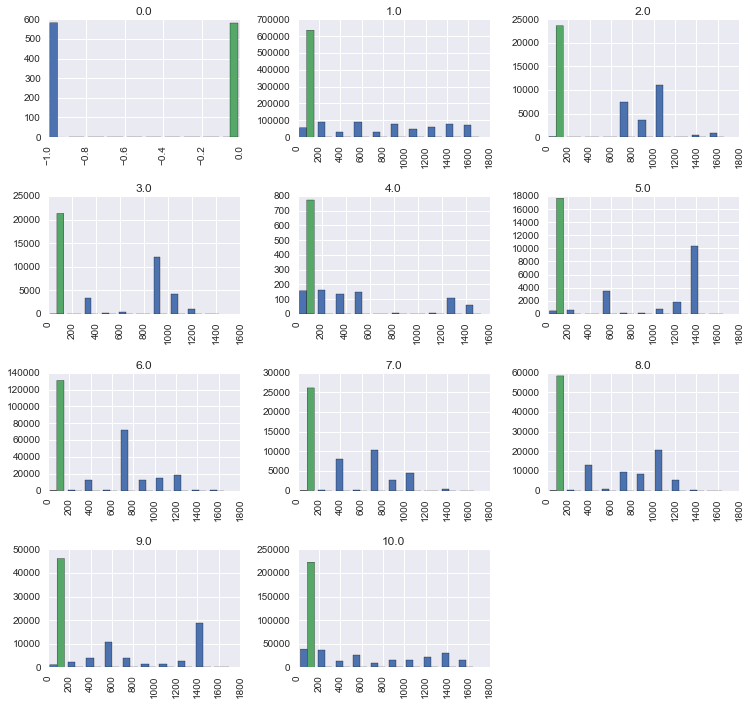

In [26]:
sample_info[['t_min','cluster']].hist(by='cluster', figsize=(12,12))
a=1

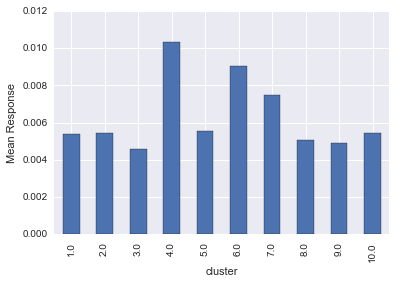

In [27]:
f = plt.figure()
ax=sample_agg.Response_x.plot(kind='bar')
ax.set_ylabel('Mean Response')

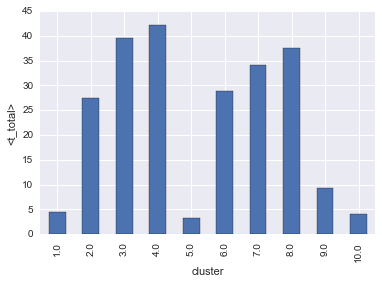

In [28]:
f = plt.figure()
ax=sample_agg['max'].plot(kind='bar')
ax.set_ylabel('<t_total>')

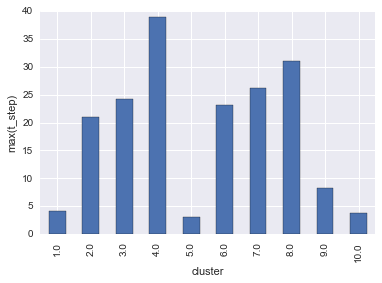

In [29]:
f = plt.figure()
ax=sample_agg['delta_max'].plot(kind='bar')
ax.set_ylabel('max(t_step)')

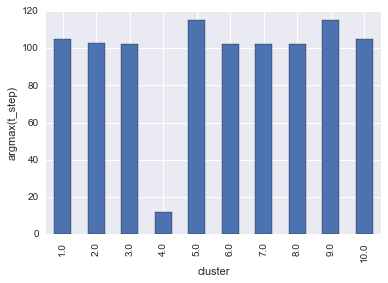

In [30]:
f = plt.figure()
ax=sample_agg['n_max'].plot(kind='bar')
ax.set_ylabel('argmax(t_step)')